<a href="https://colab.research.google.com/github/MaYuetong/MaYuetong/blob/main/Regional_mapbubble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
!pip install cartopy geopandas pandas matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])


<ipython-input-4-e726b3076624>:73: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {ur

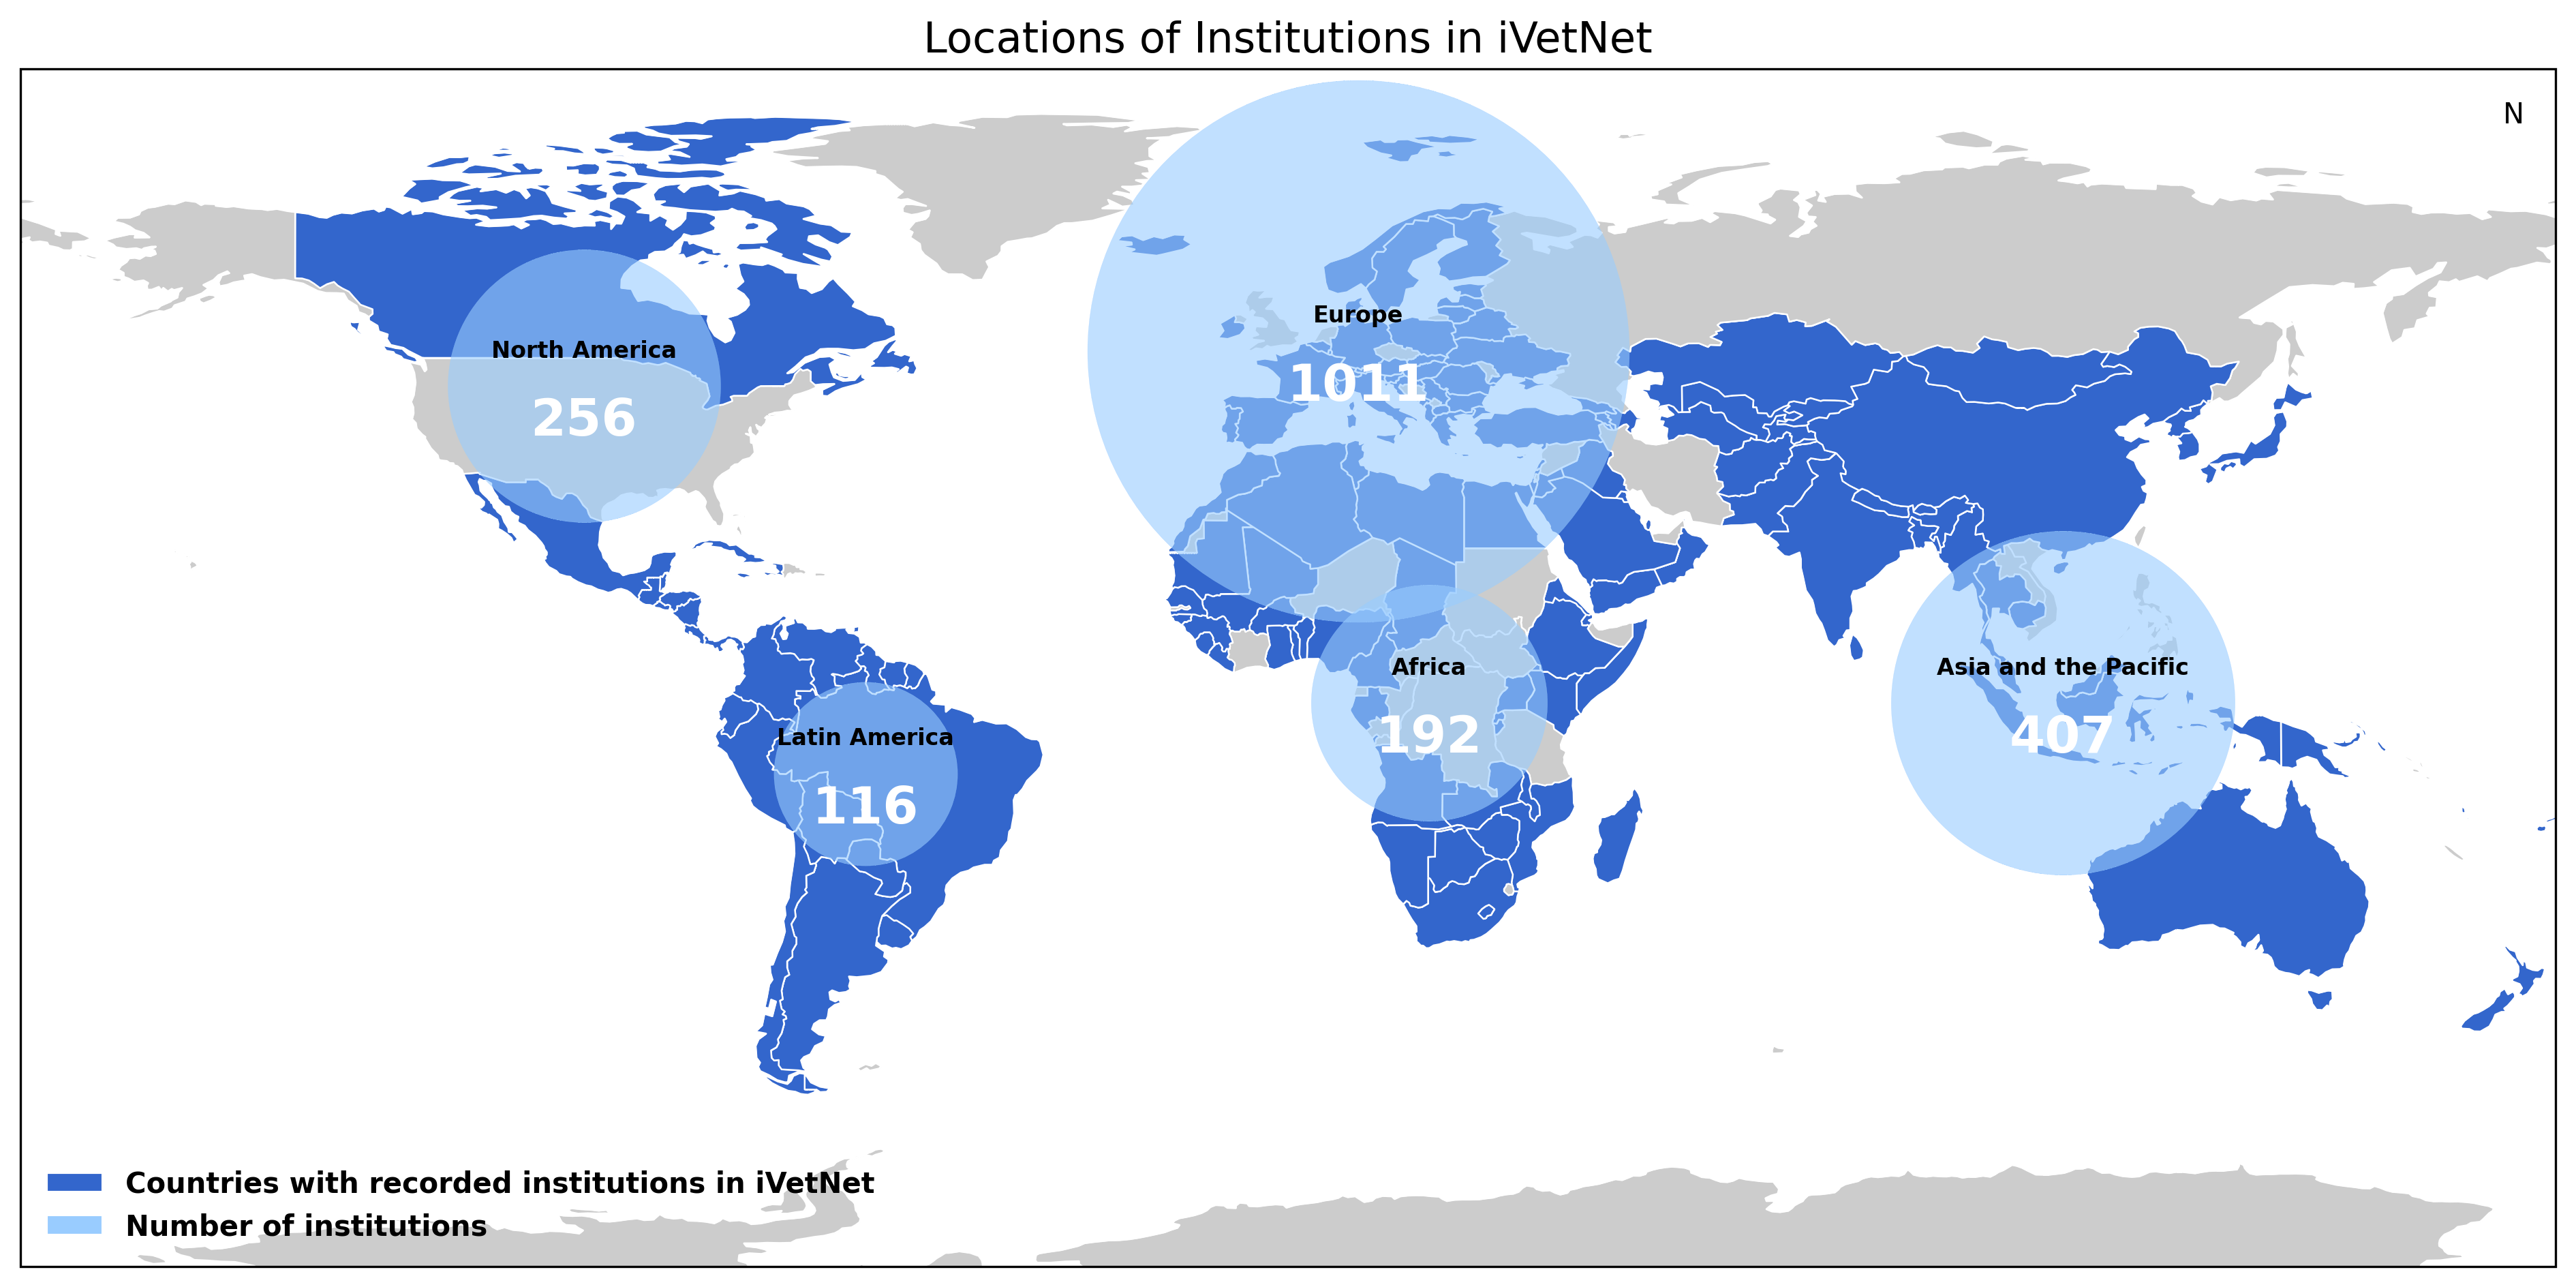

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text

bubble_color = '#99ccff'
text_color = 'black'
highlighted_country_color = '#3366cc'
default_country_color = '#cccccc'
text_color2 = 'white'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.6, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=8, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries with recorded institutions in iVetNet'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Locations of Institutions in iVetNet', size=15)
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# Show plot
plt.show()

<ipython-input-21-126f340c8a02>:77: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


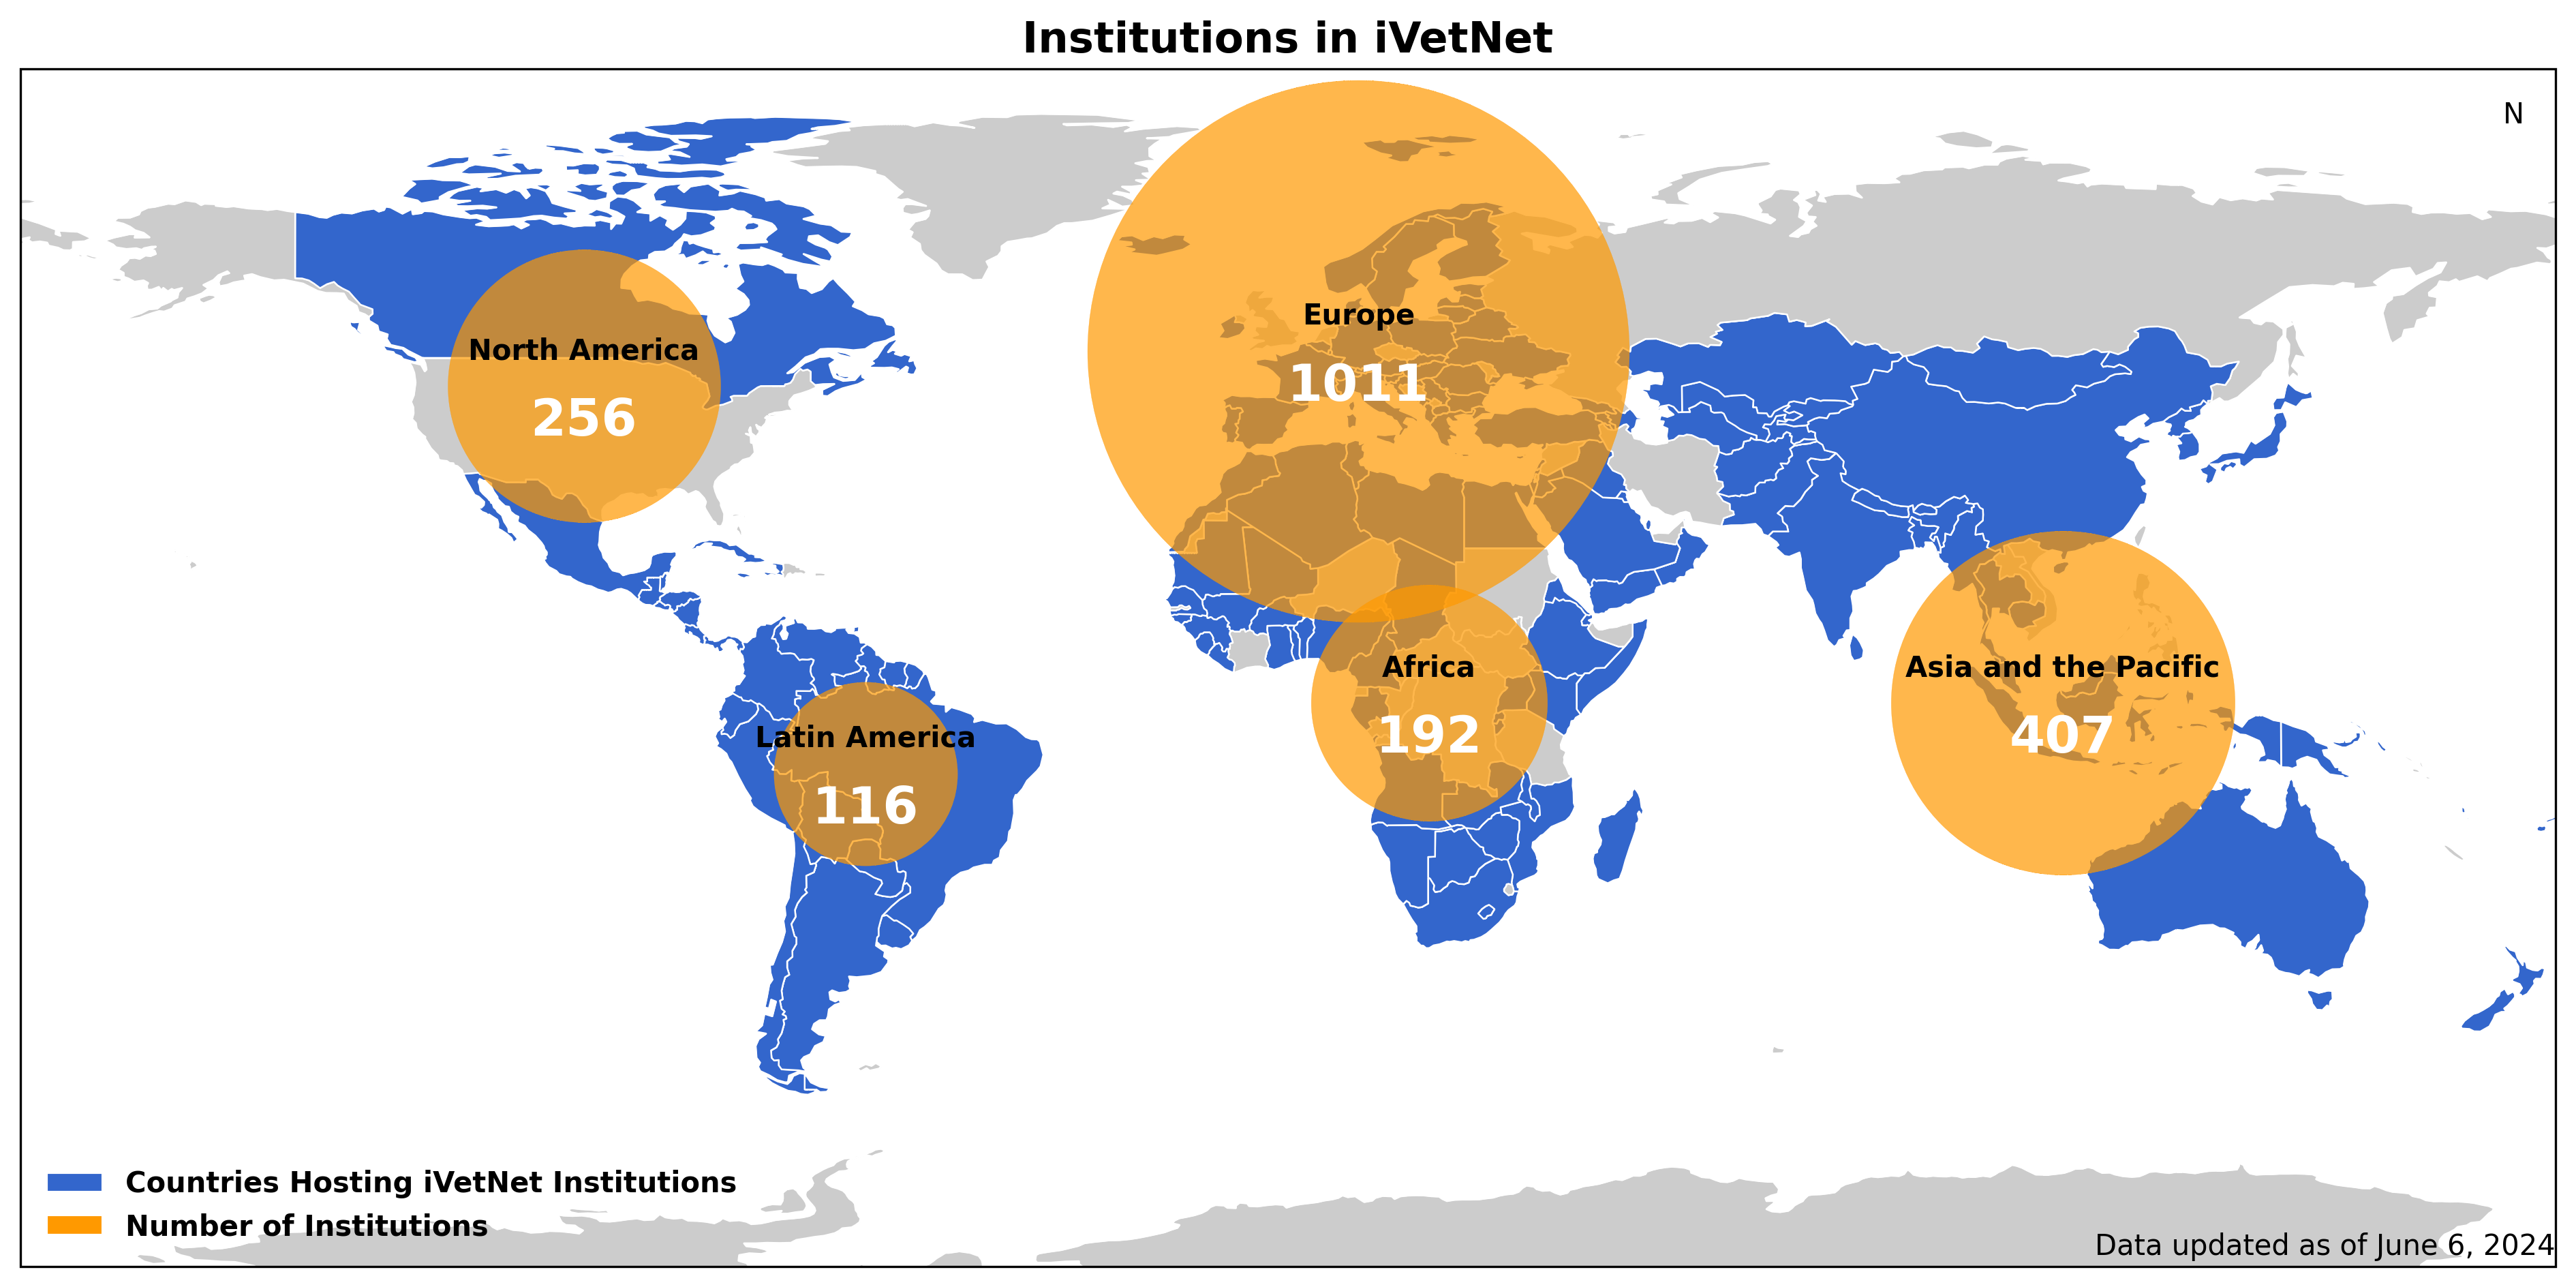

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text
#bubble_color = '#fcd3c1'
#text_color = '#e5a487'
#highlighted_country_color = '#c7c4e2'
#default_country_color = '#cccccc'

bubble_color = '#ff9900'
text_color = 'black'
highlighted_country_color = '#3366cc'
default_country_color = '#cccccc'
text_color2 = 'white'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.7, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=10, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries Hosting iVetNet Institutions'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of Institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Institutions in iVetNet', size=15, weight='bold')
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# 添加更新日期
update_text = 'Data updated as of June 6, 2024'
ax.text(1, 0.01, update_text, transform=ax.transAxes, fontsize=10, ha='right')


# save image
#plt.savefig('/content/drive/MyDrive/figures/locations_of_institutions1.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


<ipython-input-14-c4635e5790c9>:72: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


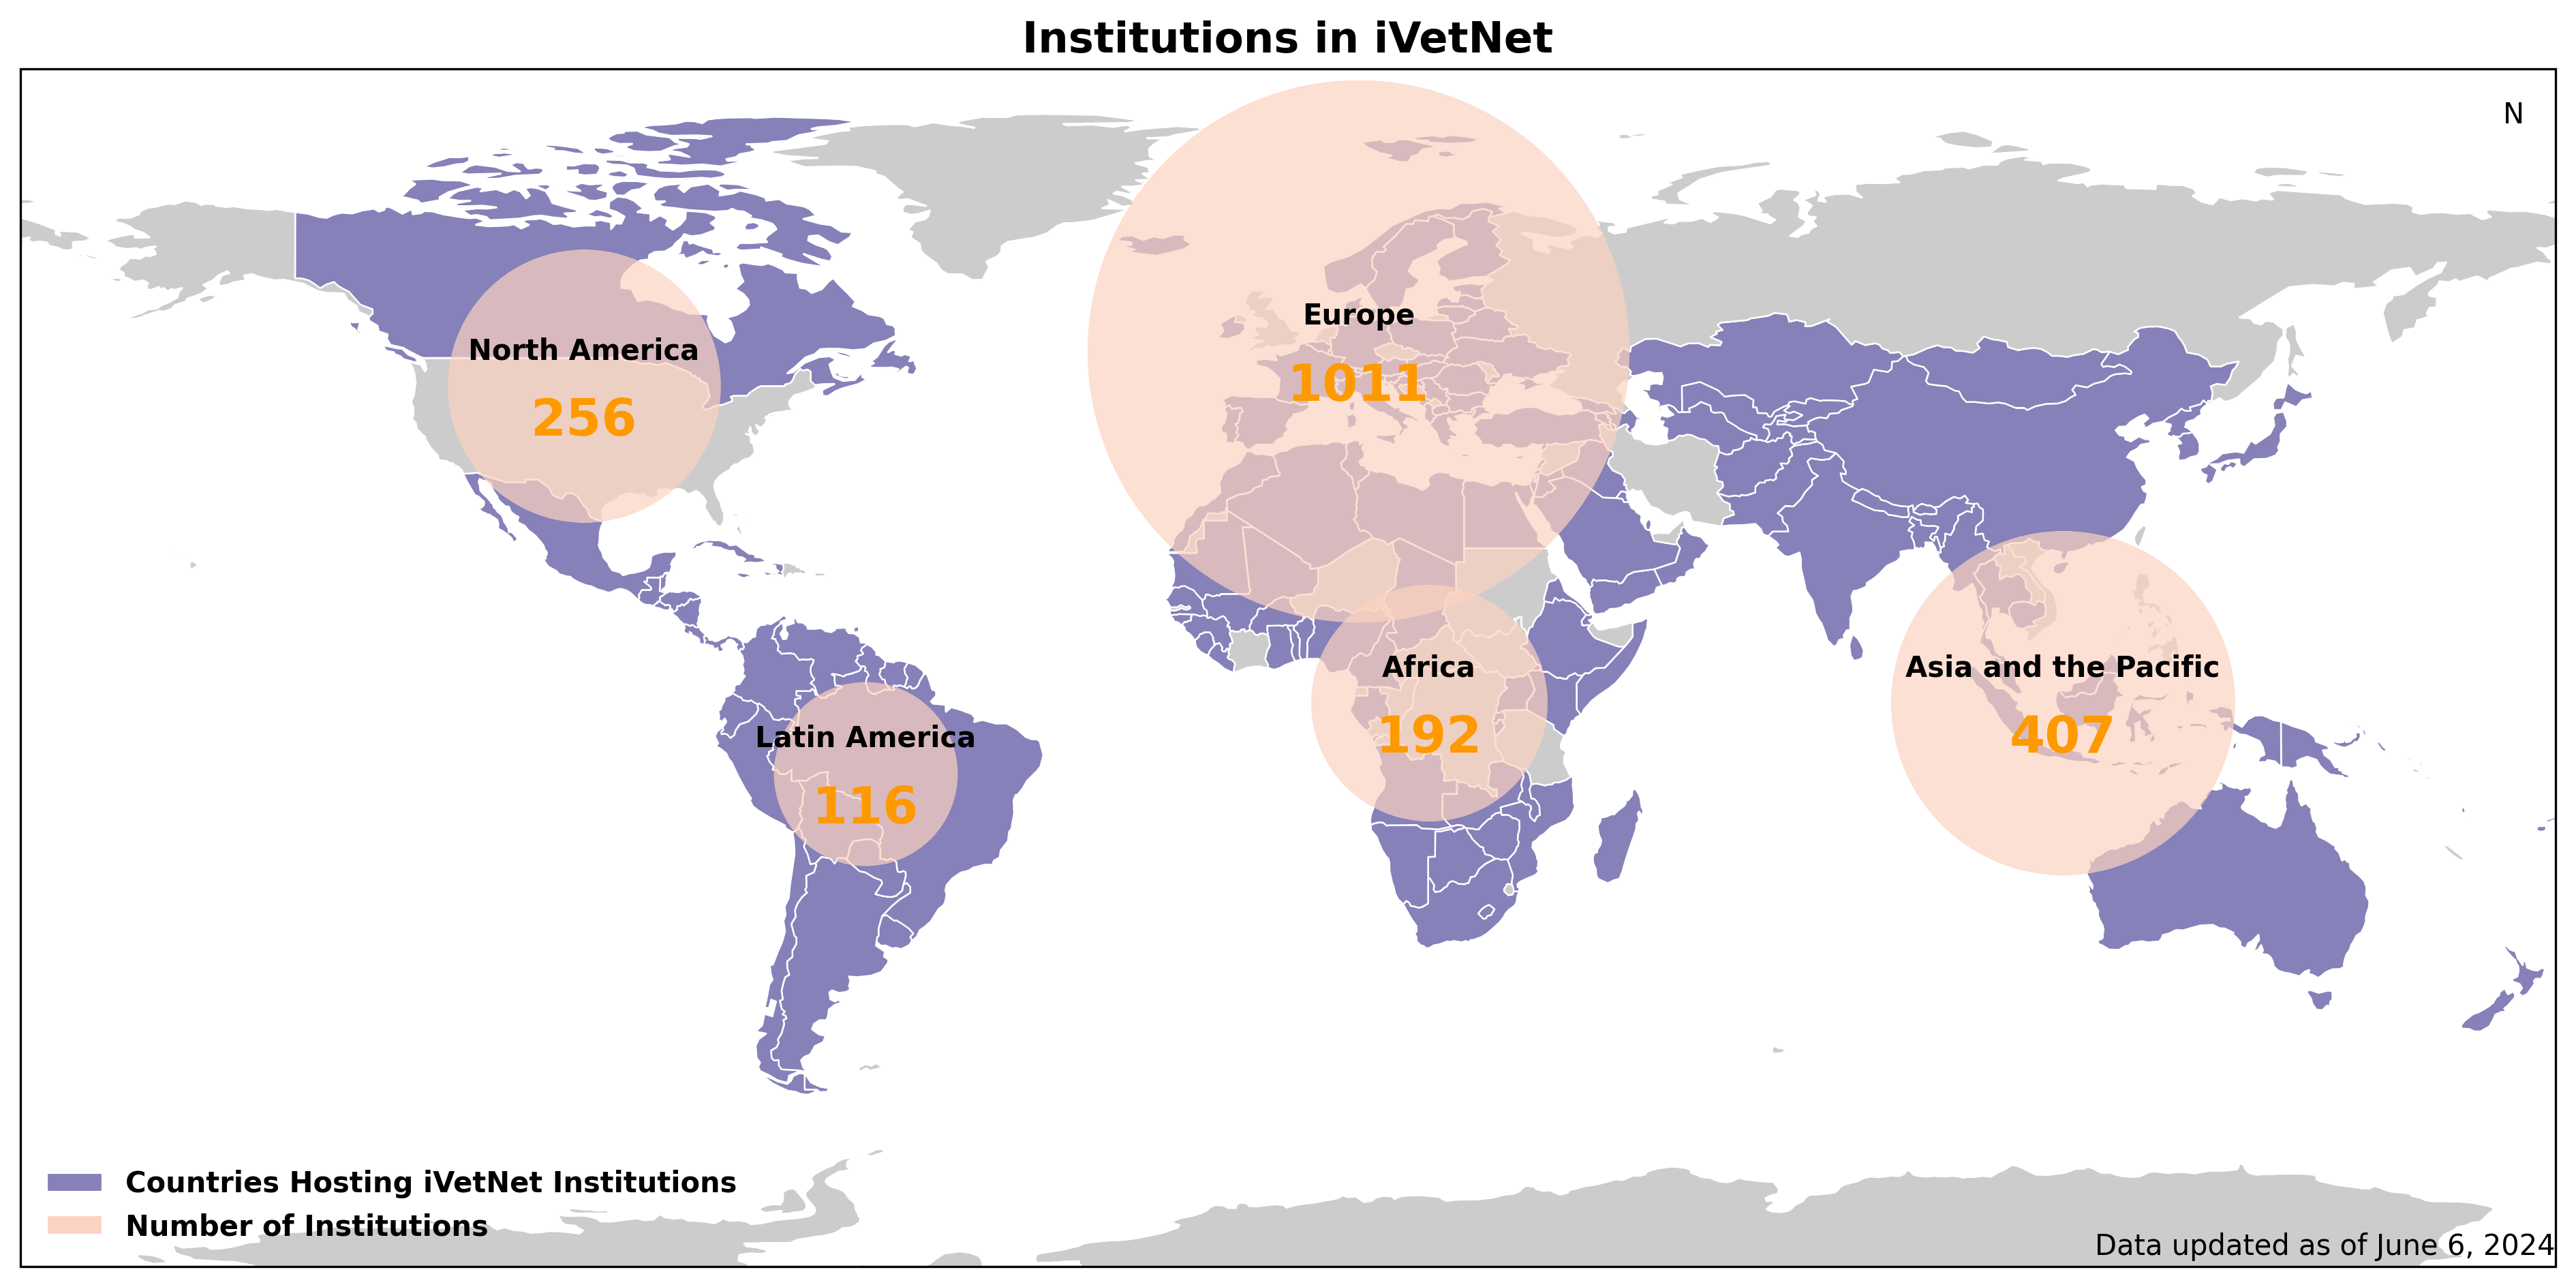

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text
bubble_color = '#fcd3c1'
text_color = 'black'
highlighted_country_color = '#8681b8'
default_country_color = '#cccccc'
text_color2 = '#ff9900'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.7, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=10, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries Hosting iVetNet Institutions'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of Institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Institutions in iVetNet', size=15, weight='bold')
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# 添加更新日期
update_text = 'Data updated as of June 6, 2024'
ax.text(1, 0.01, update_text, transform=ax.transAxes, fontsize=10, ha='right')


# save image
plt.savefig('/content/drive/MyDrive/figures/locations_of_institutions2.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


<ipython-input-19-fdf3b816cd60>:72: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


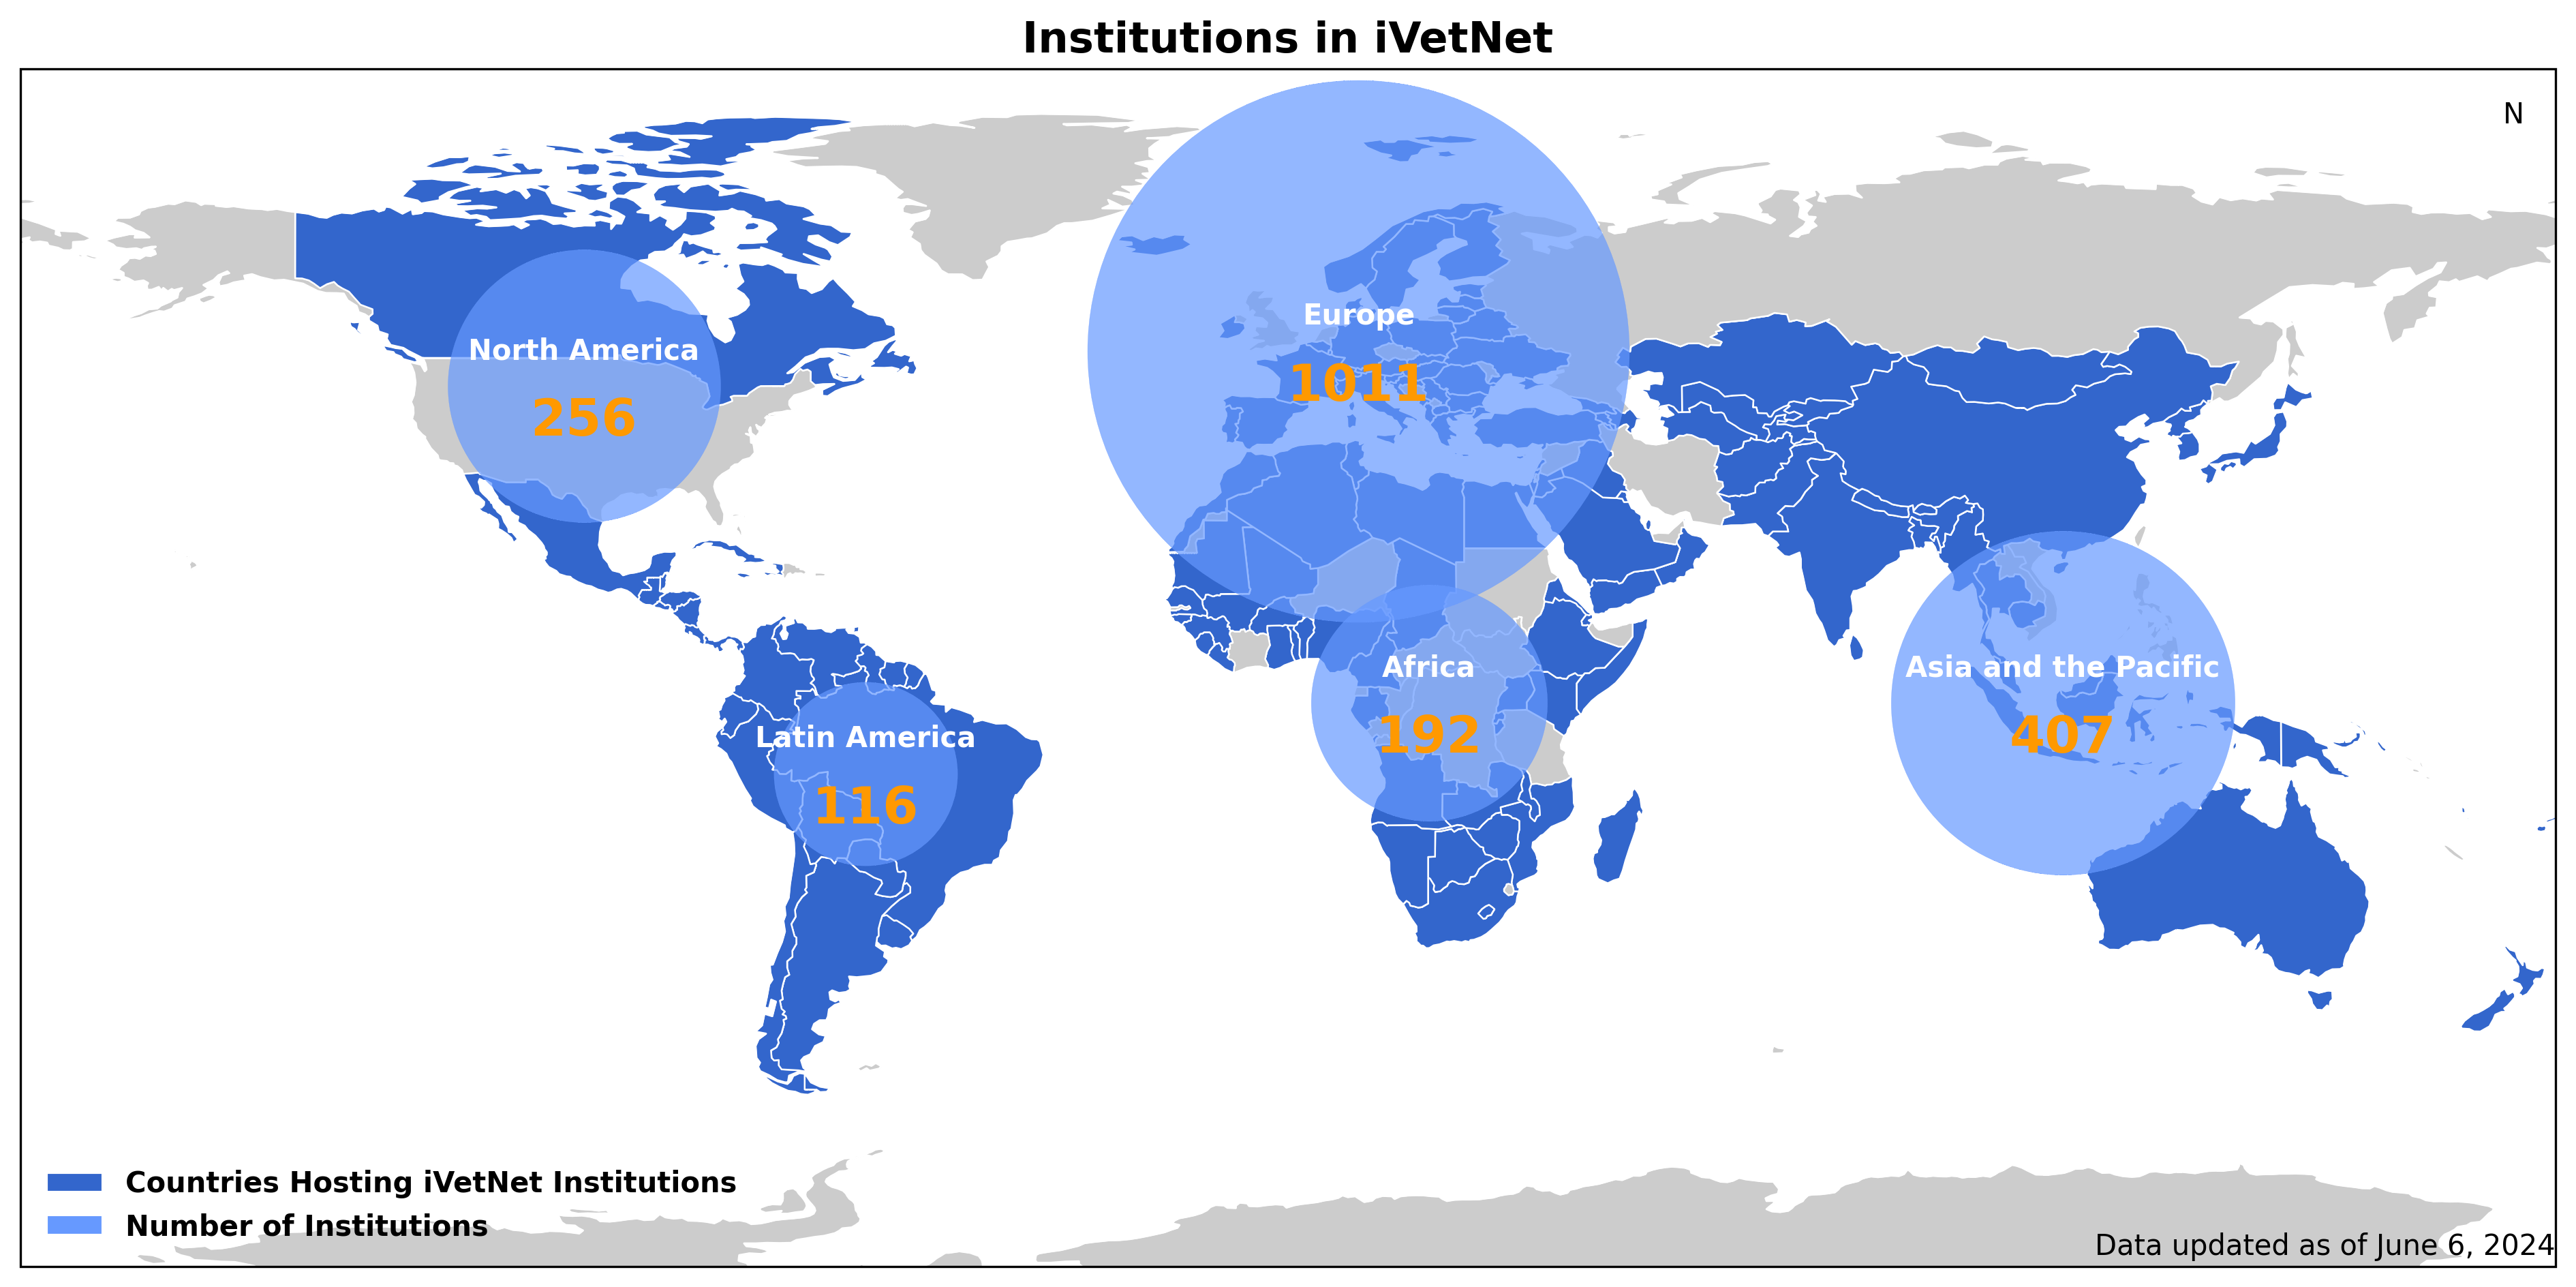

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch, Circle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects

# 设置字体
font_arial = FontProperties(fname='/usr/share/fonts/truetype/arial.ttf', weight='bold')
font_helvetica = FontProperties(fname='/usr/share/fonts/truetype/helvetica.ttf', weight='bold')

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/processed_iVetNet_Institutions.xlsx'
df = pd.read_excel(file_path)

# Remove rows with NaN values in the 'InstCat' column
df = df.dropna(subset=['InstCat'])

# Function to classify regions
def classify_region(lon, lat):
    if lon < -30:
        if lat > 0:
            return 'North America'
        else:
            return 'Latin America'
    elif lon > 60:
        return 'Asia and the Pacific'
    elif -30 <= lon <= 60 and lat > 0:
        return 'Europe'
    elif lon >= -30 and lon <= 60 and lat < 0:
        return 'Africa'
    else:
        return 'Other'

# Apply the classification function
df['Region'] = df.apply(lambda row: classify_region(row['Place_GRF_Lon'], row['Place_GRF_Lat']), axis=1)

# Calculate the number of institutions in each region
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']

# Define the coordinates for each region
region_coords = {
    'North America': (-100, 45),
    'Asia and the Pacific': (110, 0),
    'Europe': (10, 50),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

# Define the color for bubbles and text
bubble_color = '#6699ff'
text_color = 'white'
highlighted_country_color = '#3366cc'
default_country_color = '#cccccc'
text_color2 = '#ff9900'

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Place_GRF_Lon, df.Place_GRF_Lat))

# Set coordinate system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Get a list of countries with institutions
countries_with_institutions = df['Country'].unique()

# Load natural earth data for countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a new column in the world GeoDataFrame to store the color
world['color'] = default_country_color

# Update the color for countries with institutions
world.loc[world['name'].isin(countries_with_institutions), 'color'] = highlighted_country_color

# Create figure and axis with a different projection
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot countries with the assigned colors
for _, row in world.iterrows():
    ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=row['color'], edgecolor='white', linewidth=0.3)

# Draw the base world map with white coastlines and borders, fill land with a light color
ax.add_feature(cfeature.LAND, facecolor=default_country_color)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.6)

# Plot the bubbles for each region
for (region, (x, y)) in region_coords.items():
    count = region_counts.loc[region_counts['Region'] == region, 'Count'].values[0]
    ax.scatter(x, y, s=count*36, color=bubble_color, transform=ccrs.PlateCarree(), alpha=0.7, edgecolors=bubble_color, linewidth=0.1,zorder=5)

    # Add the region name
    ax.text(x, y + 5, region, color=text_color, fontsize=10, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))
    # Add the count
    ax.text(x, y - 5, f'{count}', color=text_color2, fontsize=18, ha='center', va='center', weight='bold', transform=ccrs.PlateCarree(), zorder=6, fontproperties=FontProperties(weight='bold'))


# Set the extent to focus on the northern hemisphere
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())

# Add legend
legend_elements = [
    Patch(facecolor=highlighted_country_color, edgecolor='white', label='Countries Hosting iVetNet Institutions'),
    Circle((0, 0), radius=10, facecolor=bubble_color, edgecolor='white', label='Number of Institutions')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize='large', frameon=False, prop=FontProperties(weight='bold'))

# Add professional north arrow
north_arrow = AnchoredText('N', loc='upper right', frameon=False, pad=0.6, borderpad=0.5)
ax.add_artist(north_arrow)
arrow_props = dict(facecolor='white', edgecolor='white', width=6, headwidth=12, headlength=10)
ax.annotate('', xy=(0.97, 0.97), xytext=(0.97, 0.92),
            arrowprops=arrow_props, xycoords='axes fraction', ha='center', va='center')

# Title and labels
plt.title('Institutions in iVetNet', size=15, weight='bold')
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)

# 添加更新日期
update_text = 'Data updated as of June 6, 2024'
ax.text(1, 0.01, update_text, transform=ax.transAxes, fontsize=10, ha='right')


# save image
plt.savefig('/content/drive/MyDrive/figures/locations_of_institutions3.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [1]:
!pip install pandas geopandas matplotlib plotly wordcloud
!apt-get install -y ttf-mscorefonts-installer
!fc-cache -f -v
!apt-get install -y fonts-arial

# Step 2: Google Drive
from google.colab import drive
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-update-manager python3-yaml
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n ubuntu-release-upgrader-core
  update-manager-core update-notifier-common xfonts-encodings xfonts-utils zstd
Suggested packages:
  shunit2
The following NEW packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-update-manager python3-yaml
  ttf-mscorefonts-installer ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common xfonts-encodings
  xfonts-utils zstd
0 upgraded, 21 newly installed, 0 to remove and 45

   Institution ID                                   Institution Name  \
0              14  Friedrich-Loeffler-Institute (FLI) - Jena;Fede...   
1             119  Ministry of Agriculture (MOA) and Rural Develo...   
2             119  Ministry of Agriculture (MOA) and Rural Develo...   
3             191        Minister of Agriculture;Veterinary Services   
4             423  Institute for Livestock Research and Developme...   

                                    Address                 Place  \
0                       Naumburger Str. 96a            07743 Jena   
1  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
2  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
3                       30 rue Alain Savary  1002 Tunis Belvédère   
4                     Farcha street; BP 433             N'Djamena   

  Country Name Iaea Region Name         Participant Name Gender Date Of Birth  \
0      Germany           Europe       SEYBOLDT Christian   Male        

<ipython-input-57-33c5257750f1>:15: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



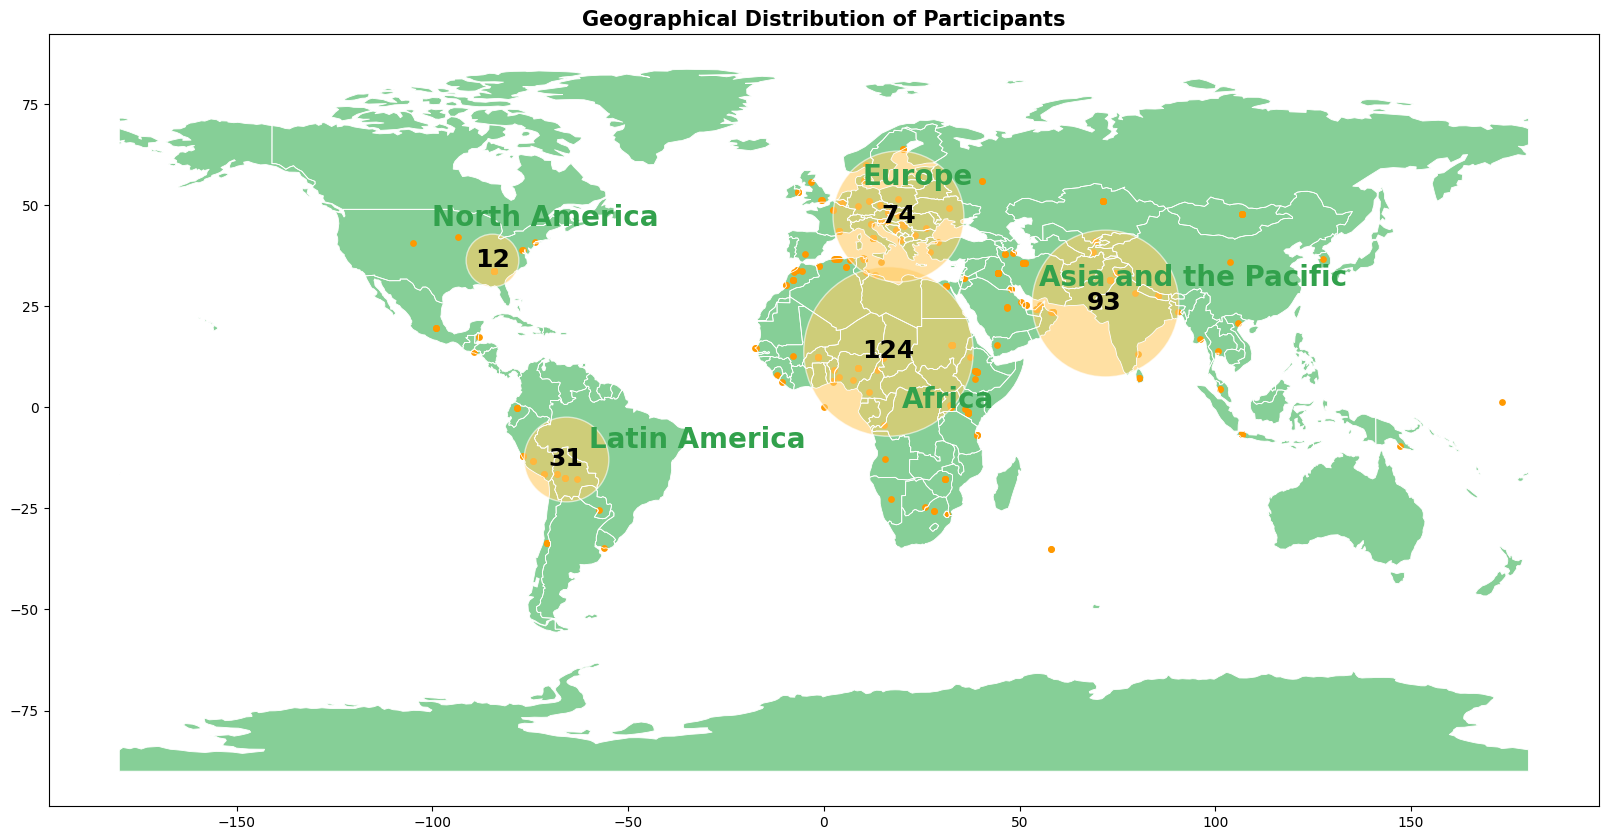

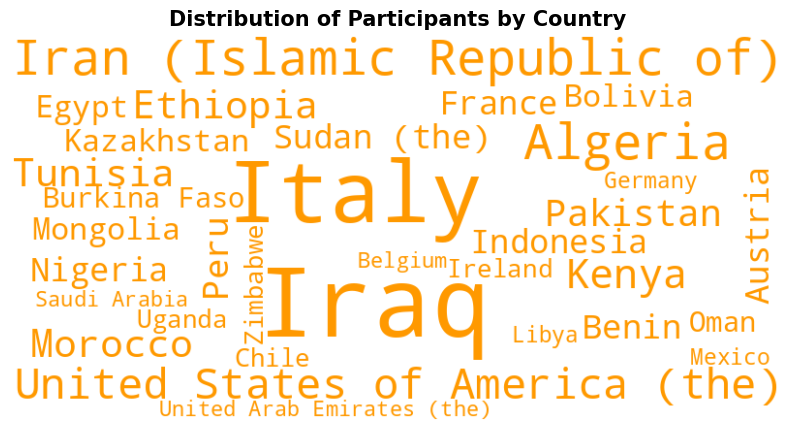

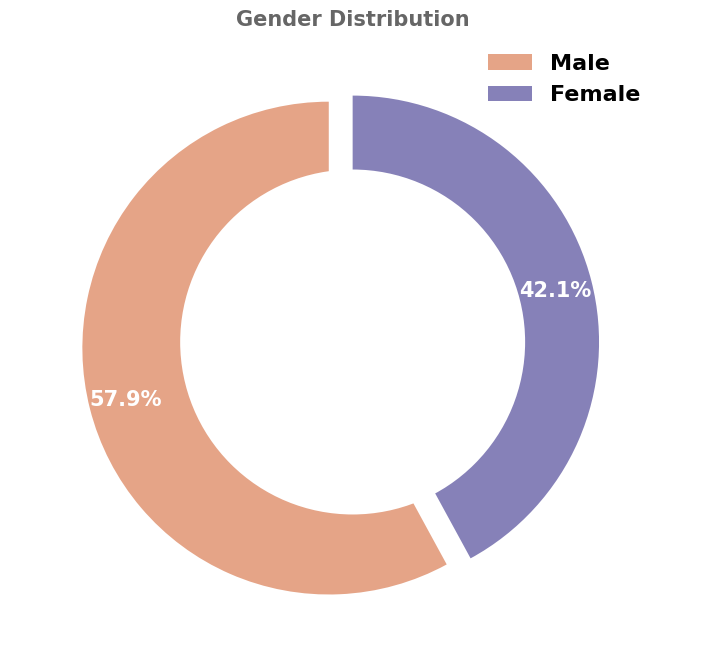

In [57]:
# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())

# 1. Geographical Map using Geopandas with additional features
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Institution Longitude'], df['Institution Latitude']),
    crs="EPSG:4326"
)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

world.boundary.plot(ax=ax, linewidth=0.6, color='white')
world.plot(ax=ax, color='#86cf97')
gdf.plot(ax=ax, color='#ff9900', markersize=15)

# Define the coordinates for each region
continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (55, 30),
    'Europe': (10, 55),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

for continent, (x, y) in continents.items():
    plt.text(x, y, continent, fontsize=20, color='#32a14c', weight='bold')

# Adding participant counts per region as bubbles
region_counts = df['Iaea Region Name'].value_counts()
for region, count in region_counts.items():
    region_data = df[df['Iaea Region Name'] == region]
    mean_lat = region_data['Institution Latitude'].mean()
    mean_lon = region_data['Institution Longitude'].mean()
    plt.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#ffcc66', edgecolors='white')
    plt.text(mean_lon, mean_lat, str(count), fontsize=18, color='black', ha='center', va='center', weight='bold')

plt.title('Geographical Distribution of Participants', fontname='Arial', size=15, weight='bold')
plt.show()

# 2. Word Cloud for distribution of participants by country
from wordcloud import WordCloud

country_counts = df['Country Name'].value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      color_func=lambda *args, **kwargs: '#ff9900',
                      max_font_size=100, min_font_size=20).generate_from_frequencies(country_counts)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Distribution of Participants by Country', fontname='Arial', size=15, weight='bold')
plt.show()

# 4. Pie Chart for gender distribution
gender_counts = df['Gender'].value_counts()

# Setting up the colors
colors = ['#e5a487', '#8681b8']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, pctdistance=0.85, textprops={'fontsize': 15, 'fontweight': 'bold', 'color': 'white', 'fontname':'Arial'})

# Draw center circle for 'donut' effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gender Distribution', color='#666666', fontname='Arial', size=15, weight='bold')

# Add legend
plt.legend(labels=['Male', 'Female'], loc="upper right", fontsize=16, frameon=False, prop={'size': 16, 'weight': 'bold', 'family': 'Georgia'})

plt.show()

In [ ]:
# Step 1: 安装必要的库
!pip install pandas geopandas matplotlib wordcloud

# Step 2: 从Google Drive加载数据
from google.colab import drive
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 挂载Google Drive
drive.mount('/content/drive')


   Institution ID                                   Institution Name  \
0              14  Friedrich-Loeffler-Institute (FLI) - Jena;Fede...   
1             119  Ministry of Agriculture (MOA) and Rural Develo...   
2             119  Ministry of Agriculture (MOA) and Rural Develo...   
3             191        Minister of Agriculture;Veterinary Services   
4             423  Institute for Livestock Research and Developme...   

                                    Address                 Place  \
0                       Naumburger Str. 96a            07743 Jena   
1  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
2  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
3                       30 rue Alain Savary  1002 Tunis Belvédère   
4                     Farcha street; BP 433             N'Djamena   

  Country Name Iaea Region Name         Participant Name Gender Date Of Birth  \
0      Germany           Europe       SEYBOLDT Christian   Male        

<ipython-input-4-7d5a48986fd5>:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-4-7d5a48986fd5>:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centroid'] = world['geometry'].centroid
<ipython-input-4-7d5a48986fd5>:89: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-4-7d5a48986fd5>:58: FutureWarning: The geopandas.dataset module is

GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

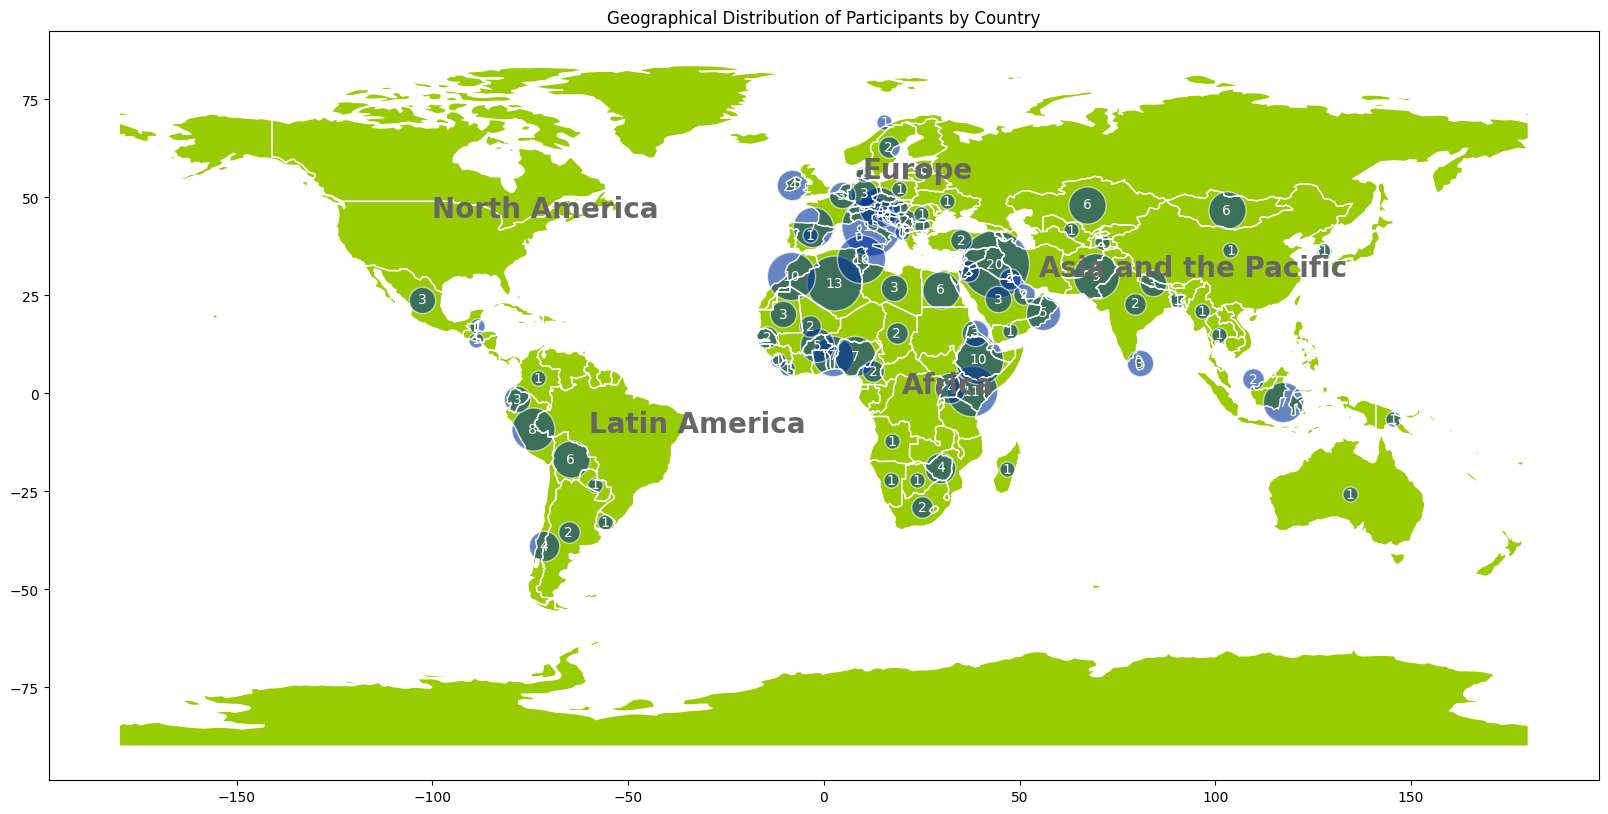

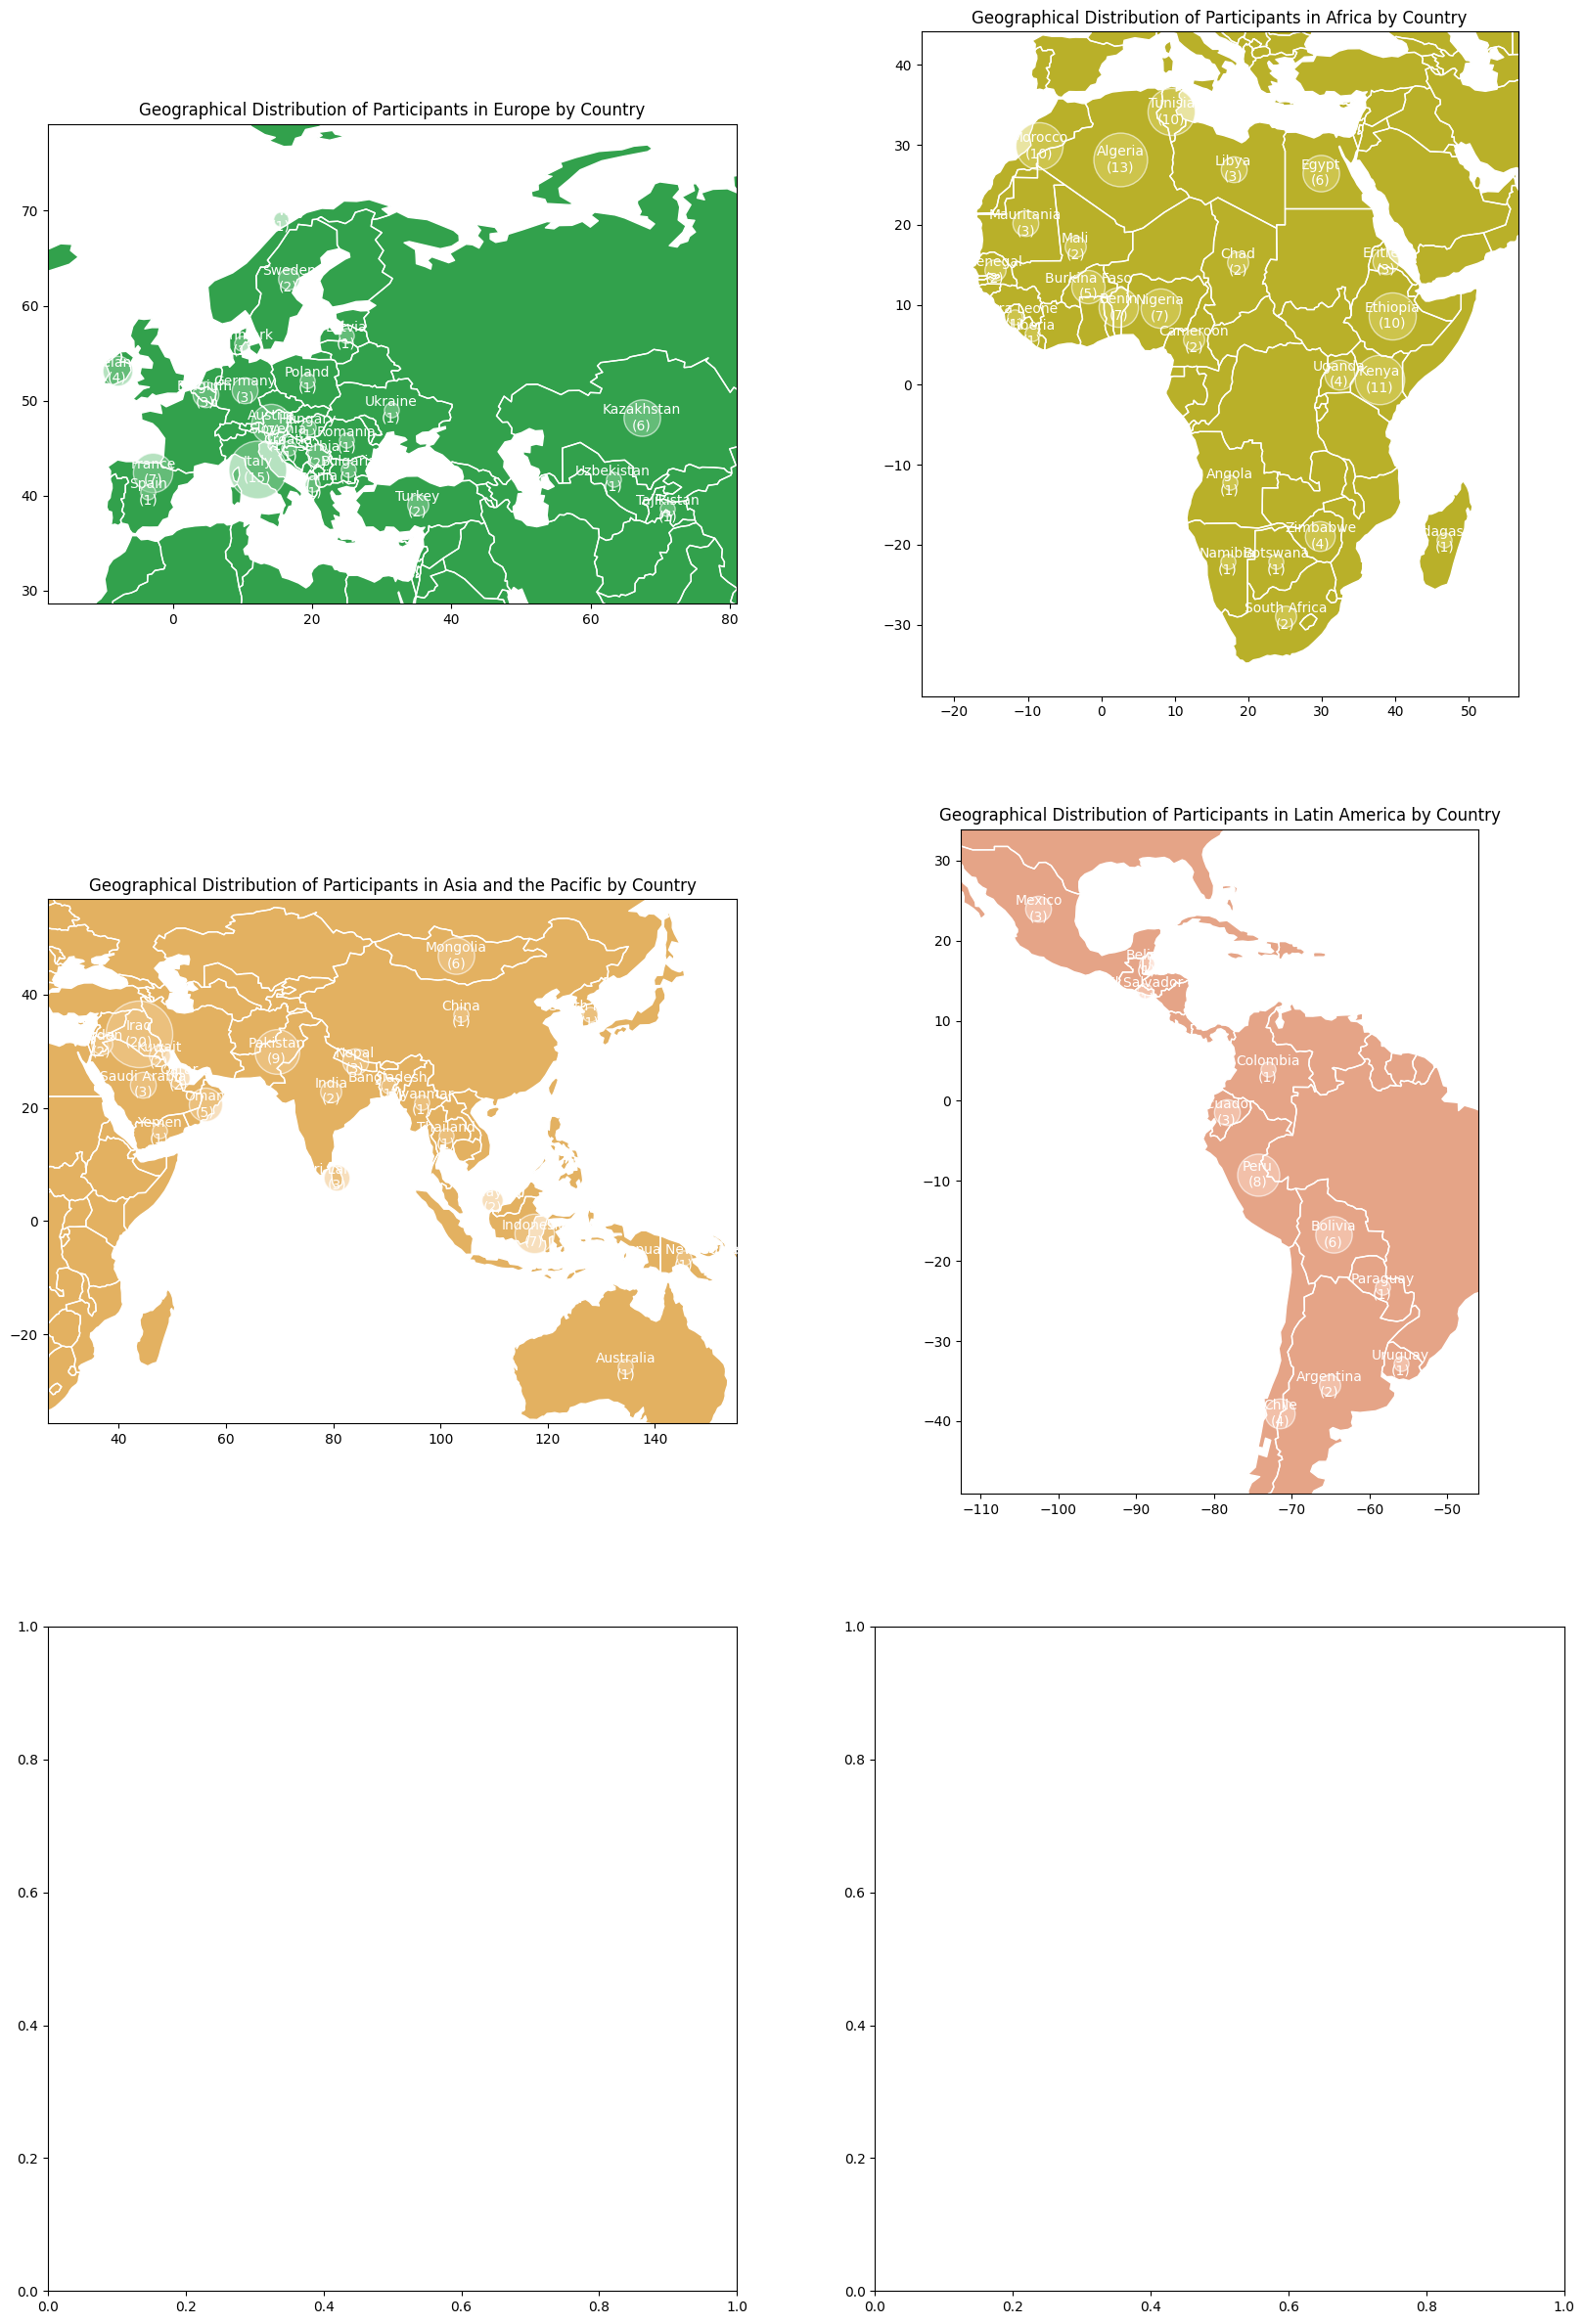

In [4]:

# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())

# 上传并使用微软雅黑字体
!wget https://github.com/google/fonts/blob/main/apache/microsoftyahei/MicrosoftYaHei.ttf?raw=true -O /usr/share/fonts/truetype/msyh.ttf
!fc-cache -f -v

# 颜色搭配
color_schemes = [
    ['#32a14c', '#86cf97'],
    ['#b9b029', '#dbd365'],
    ['#e3b161', '#f2cb91'],
    ['#e5a487', '#fcd3c1'],
    ['#8681b8', '#c7c4e2']
]

# 获取国家的几何中心
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs("EPSG:4326")  # 确保使用WGS84坐标系
world['centroid'] = world['geometry'].centroid

# 为数据框中的每个国家分配几何中心
df['country_centroid'] = df['Country Name'].map(lambda x: world[world['name'] == x]['centroid'].values[0] if x in world['name'].values else None)

# 将几何中心分为经度和纬度
df['centroid_lon'] = df['country_centroid'].apply(lambda x: x.x if x else None)
df['centroid_lat'] = df['country_centroid'].apply(lambda x: x.y if x else None)

# Step 3: 可视化

# 1. Map with country-level participant bubbles
def plot_country_bubble_map(ax, df, title, world, continents):
    world.boundary.plot(ax=ax, linewidth=1, color='white')
    world.plot(ax=ax, color='#99cc00')  # 陆地填充颜色

    country_counts = df['Country Name'].value_counts()
    for country, count in country_counts.items():
        country_data = df[df['Country Name'] == country]
        mean_lat = country_data['centroid_lat'].mean()
        mean_lon = country_data['centroid_lon'].mean()
        ax.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#003399', edgecolors='white')
        ax.text(mean_lon, mean_lat, str(count), fontsize=10, color='white', ha='center', va='center', fontname='Microsoft YaHei')

    for continent, (x, y) in continents.items():
        ax.text(x, y, continent, fontsize=20, color='#666666', weight='bold', fontname='Microsoft YaHei')

    ax.set_title(title, fontname='Microsoft YaHei')

# 2. Maps for each region with country-level participant bubbles
def plot_region_bubble_maps(df, color_schemes):
    regions = df['Iaea Region Name'].unique()
    num_regions = len(regions)
    fig, axes = plt.subplots(num_regions // 2 + num_regions % 2, 2, figsize=(20, num_regions * 6))
    axes = axes.flatten()

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for i, (region, colors) in enumerate(zip(regions, color_schemes)):
        region_df = df[df['Iaea Region Name'] == region]
        region_world = world.cx[region_df['centroid_lon'].min()-20:region_df['centroid_lon'].max()+20,
                                region_df['centroid_lat'].min()-20:region_df['centroid_lat'].max()+20]

        axes[i].set_xlim(region_df['centroid_lon'].min()-10, region_df['centroid_lon'].max()+10)
        axes[i].set_ylim(region_df['centroid_lat'].min()-10, region_df['centroid_lat'].max()+10)

        region_world.boundary.plot(ax=axes[i], linewidth=1, color='white')
        region_world.plot(ax=axes[i], color=colors[0])  # 陆地填充颜色

        region_country_counts = region_df['Country Name'].value_counts()
        for country, count in region_country_counts.items():
            country_data = region_df[region_df['Country Name'] == country]
            mean_lat = country_data['centroid_lat'].mean()
            mean_lon = country_data['centroid_lon'].mean()
            axes[i].scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color=colors[1], edgecolors='white')
            axes[i].text(mean_lon, mean_lat, f"{country}\n({count})", fontsize=10, color='white', ha='center', va='center', fontname='Microsoft YaHei')

        axes[i].set_title(f'Geographical Distribution of Participants in {region} by Country', fontname='Microsoft YaHei')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# 世界地图
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (55, 30),
    'Europe': (10, 55),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

plot_country_bubble_map(ax, df, 'Geographical Distribution of Participants by Country', world, continents)

# 各区域地图
plot_region_bubble_maps(df, color_schemes)

   Institution ID                                   Institution Name  \
0              14  Friedrich-Loeffler-Institute (FLI) - Jena;Fede...   
1             119  Ministry of Agriculture (MOA) and Rural Develo...   
2             119  Ministry of Agriculture (MOA) and Rural Develo...   
3             191        Minister of Agriculture;Veterinary Services   
4             423  Institute for Livestock Research and Developme...   

                                    Address                 Place  \
0                       Naumburger Str. 96a            07743 Jena   
1  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
2  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
3                       30 rue Alain Savary  1002 Tunis Belvédère   
4                     Farcha street; BP 433             N'Djamena   

  Country Name Iaea Region Name         Participant Name Gender Date Of Birth  \
0      Germany           Europe       SEYBOLDT Christian   Male        

<ipython-input-13-c0416aeffed4>:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-13-c0416aeffed4>:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centroid'] = world['geometry'].centroid
<ipython-input-13-c0416aeffed4>:107: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-13-c0416aeffed4>:61: FutureWarning: The geopandas.dataset modu

GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

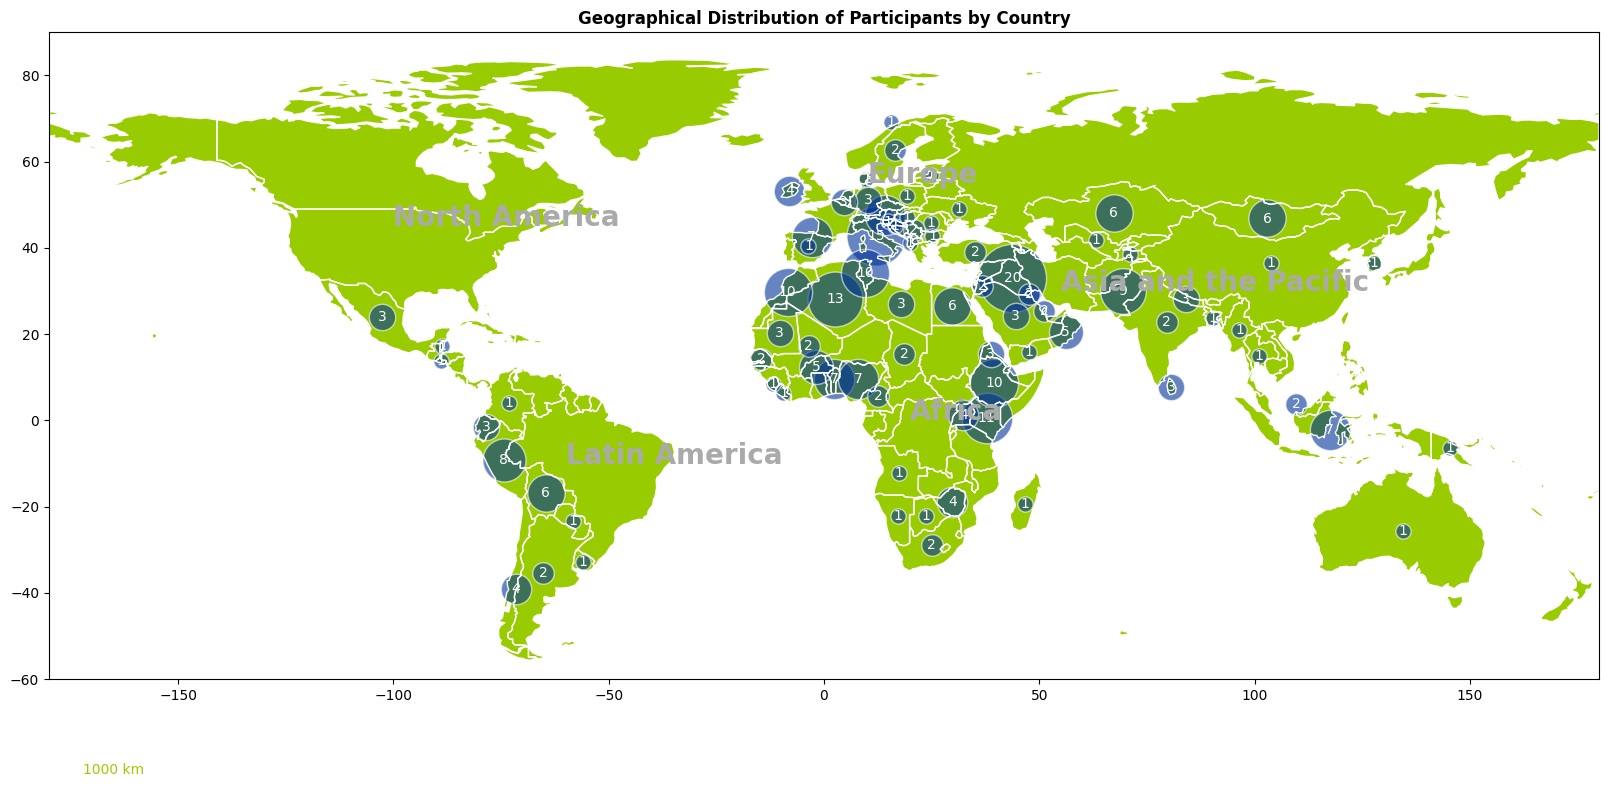

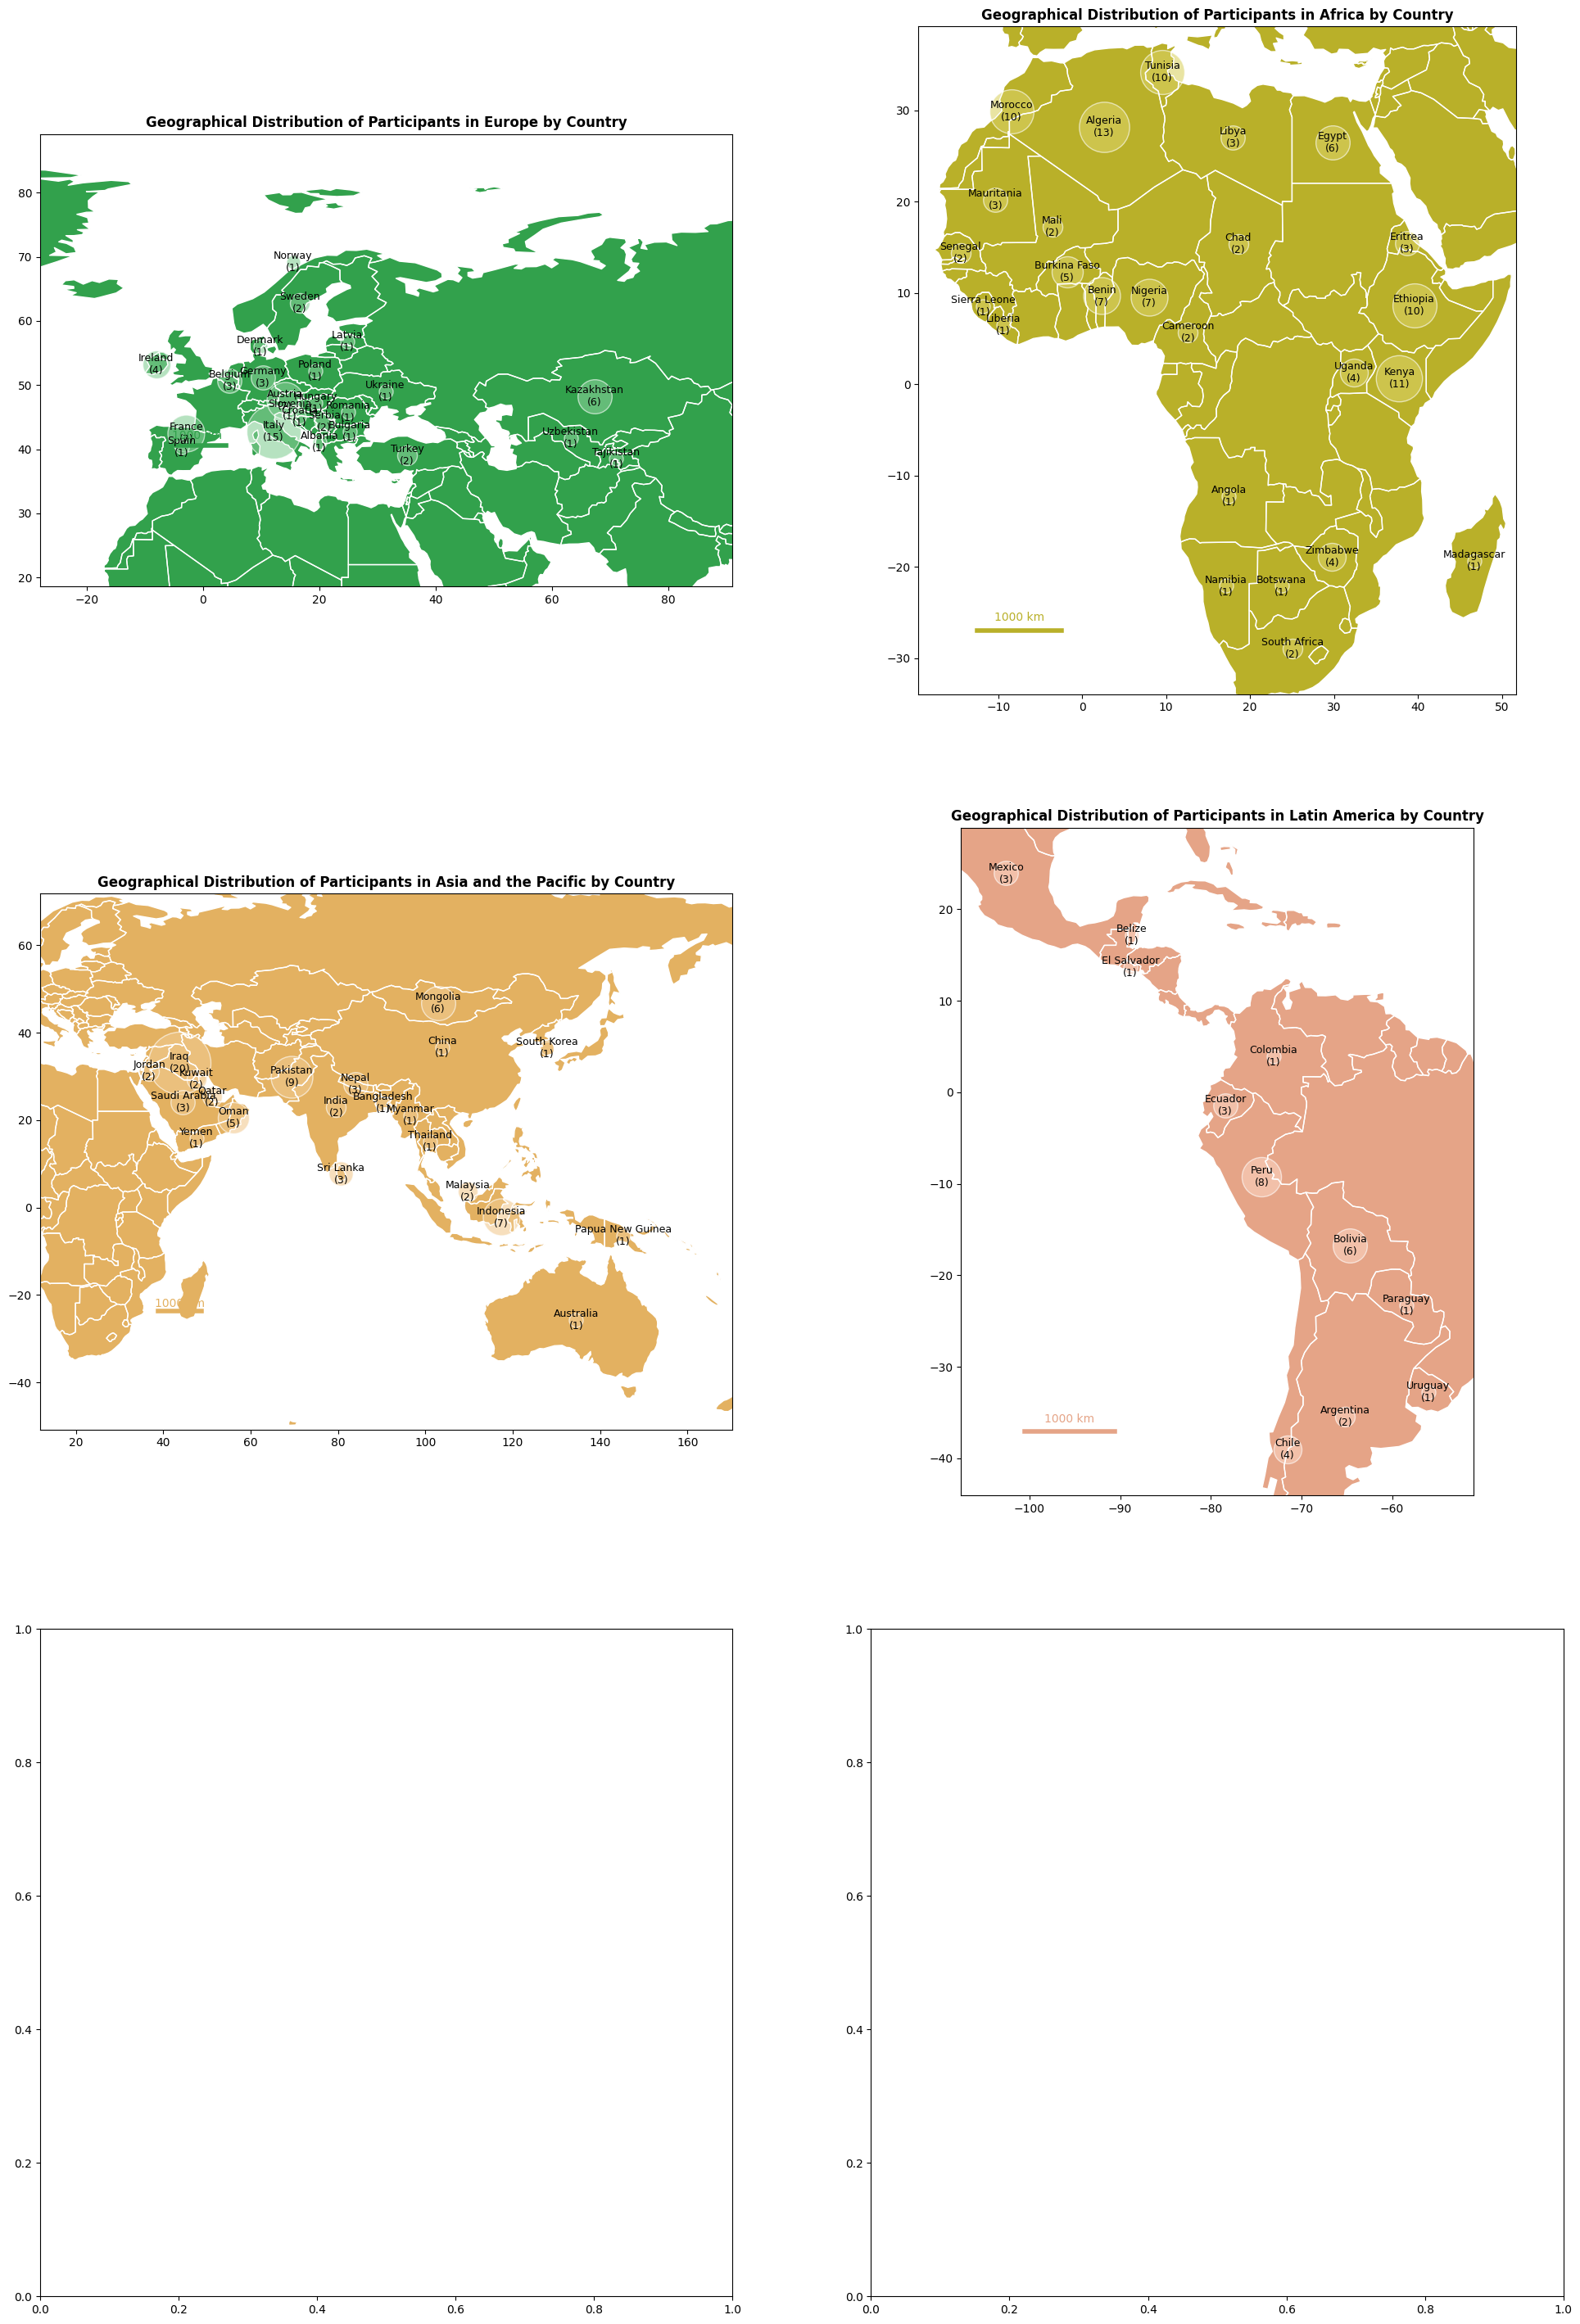

In [13]:
# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())

# 颜色搭配
color_schemes = [
    ['#32a14c', '#86cf97'],  # Asia and the Pacific
    ['#b9b029', '#dbd365'],  # Africa
    ['#e3b161', '#f2cb91'],  # Europe
    ['#e5a487', '#fcd3c1'],  # Latin America
    ['#8681b8', '#c7c4e2'],  # North America
    ['#ff9900', '#ffcc66']   #备用
]

# 获取国家的几何中心
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs("EPSG:4326")  # 确保使用WGS84坐标系
world['centroid'] = world['geometry'].centroid

# 为数据框中的每个国家分配几何中心
df['country_centroid'] = df['Country Name'].map(lambda x: world[world['name'] == x]['centroid'].values[0] if x in world['name'].values else None)

# 将几何中心分为经度和纬度
df['centroid_lon'] = df['country_centroid'].apply(lambda x: x.x if x else None)
df['centroid_lat'] = df['country_centroid'].apply(lambda x: x.y if x else None)

# Step 3: 可视化

# 1. Map with country-level participant bubbles
def plot_country_bubble_map(ax, df, title, world, continents):
    world.boundary.plot(ax=ax, linewidth=1, color='white')
    world.plot(ax=ax, color='#99cc00')  # 陆地填充颜色

    country_counts = df['Country Name'].value_counts()
    for country, count in country_counts.items():
        country_data = df[df['Country Name'] == country]
        mean_lat = country_data['centroid_lat'].mean()
        mean_lon = country_data['centroid_lon'].mean()
        ax.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#003399', edgecolors='white')
        ax.text(mean_lon, mean_lat, str(count), fontsize=10, color='white', ha='center', va='center', fontname='Arial')

    for continent, (x, y) in continents.items():
        ax.text(x, y, continent, fontsize=20, color='#aaaaaa', weight='bold', fontname='Arial')

    ax.set_title(title, fontname='Arial', weight='bold')

    # 添加比例尺
    scale_color = '#99cc00'
    ax.plot([-170, -160], [-80, -80], color=scale_color, linewidth=4)
    ax.text(-165, -82, '1000 km', fontsize=10, color=scale_color, ha='center', fontname='Arial')

# 2. Maps for each region with country-level participant bubbles
def plot_region_bubble_maps(df, color_schemes):
    regions = df['Iaea Region Name'].unique()
    regions = [region for region in regions if region != '']
    num_regions = len(regions)
    fig, axes = plt.subplots((num_regions + 1) // 2, 2, figsize=(24, (num_regions + 1) // 2 * 12))
    axes = axes.flatten()

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for i, (region, colors) in enumerate(zip(regions, color_schemes)):
        region_df = df[df['Iaea Region Name'] == region]

        if region == 'Europe':
            buffer = 40  # 增加缓冲区以避免重叠
        elif region == 'Asia and the Pacific':
            buffer = 50  # 增加缓冲区以避免重叠
        else:
            buffer = 10

        region_world = world.cx[region_df['centroid_lon'].min()-buffer:region_df['centroid_lon'].max()+buffer,
                                region_df['centroid_lat'].min()-buffer:region_df['centroid_lat'].max()+buffer]

        axes[i].set_xlim(region_df['centroid_lon'].min()-buffer/2, region_df['centroid_lon'].max()+buffer/2)
        axes[i].set_ylim(region_df['centroid_lat'].min()-buffer/2, region_df['centroid_lat'].max()+buffer/2)

        region_world.boundary.plot(ax=axes[i], linewidth=1, color='white')
        region_world.plot(ax=axes[i], color=colors[0])  # 陆地填充颜色

        region_country_counts = region_df['Country Name'].value_counts()
        for country, count in region_country_counts.items():
            country_data = region_df[region_df['Country Name'] == country]
            mean_lat = country_data['centroid_lat'].mean()
            mean_lon = country_data['centroid_lon'].mean()
            axes[i].scatter(mean_lon, mean_lat, s=count*150, alpha=0.6, color=colors[1], edgecolors='white')
            axes[i].text(mean_lon, mean_lat, f"{country}\n({count})", fontsize=9, color='black', ha='center', va='center')

        axes[i].set_title(f'Geographical Distribution of Participants in {region} by Country', weight='bold')

        # 添加比例尺
        axes[i].plot([region_df['centroid_lon'].min()+2, region_df['centroid_lon'].min()+12],
                     [region_df['centroid_lat'].min()+2, region_df['centroid_lat'].min()+2],
                     color=colors[0], linewidth=4)
        axes[i].text(region_df['centroid_lon'].min()+7, region_df['centroid_lat'].min()+3,
                     '1000 km', fontsize=10, color=colors[0], ha='center')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# 世界地图
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 调整大图的显示范围，露出更多北半球区域，隐藏南极
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 90)

continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (55, 30),
    'Europe': (10, 55),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

plot_country_bubble_map(ax, df, 'Geographical Distribution of Participants by Country', world, continents)

# 各区域地图
plot_region_bubble_maps(df, color_schemes)


   Institution ID                                   Institution Name  \
0              14  Friedrich-Loeffler-Institute (FLI) - Jena;Fede...   
1             119  Ministry of Agriculture (MOA) and Rural Develo...   
2             119  Ministry of Agriculture (MOA) and Rural Develo...   
3             191        Minister of Agriculture;Veterinary Services   
4             423  Institute for Livestock Research and Developme...   

                                    Address                 Place  \
0                       Naumburger Str. 96a            07743 Jena   
1  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
2  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
3                       30 rue Alain Savary  1002 Tunis Belvédère   
4                     Farcha street; BP 433             N'Djamena   

  Country Name Iaea Region Name         Participant Name Gender Date Of Birth  \
0      Germany           Europe       SEYBOLDT Christian   Male        

<ipython-input-20-52b125cd80c7>:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-20-52b125cd80c7>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centroid'] = world['geometry'].centroid
<ipython-input-20-52b125cd80c7>:115: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-20-52b125cd80c7>:60: FutureWarning: The geopandas.dataset modu

GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

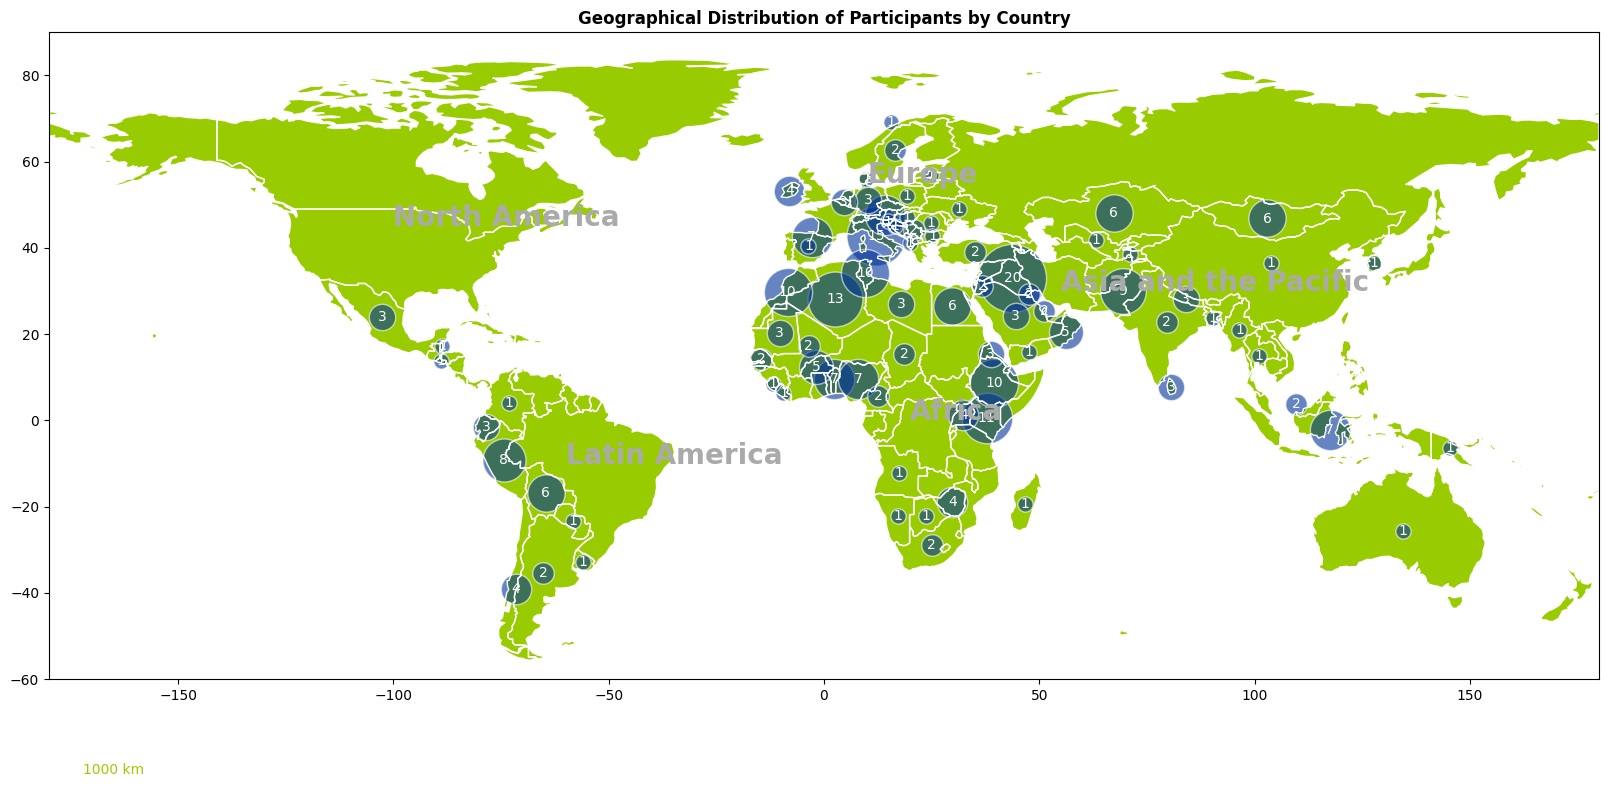

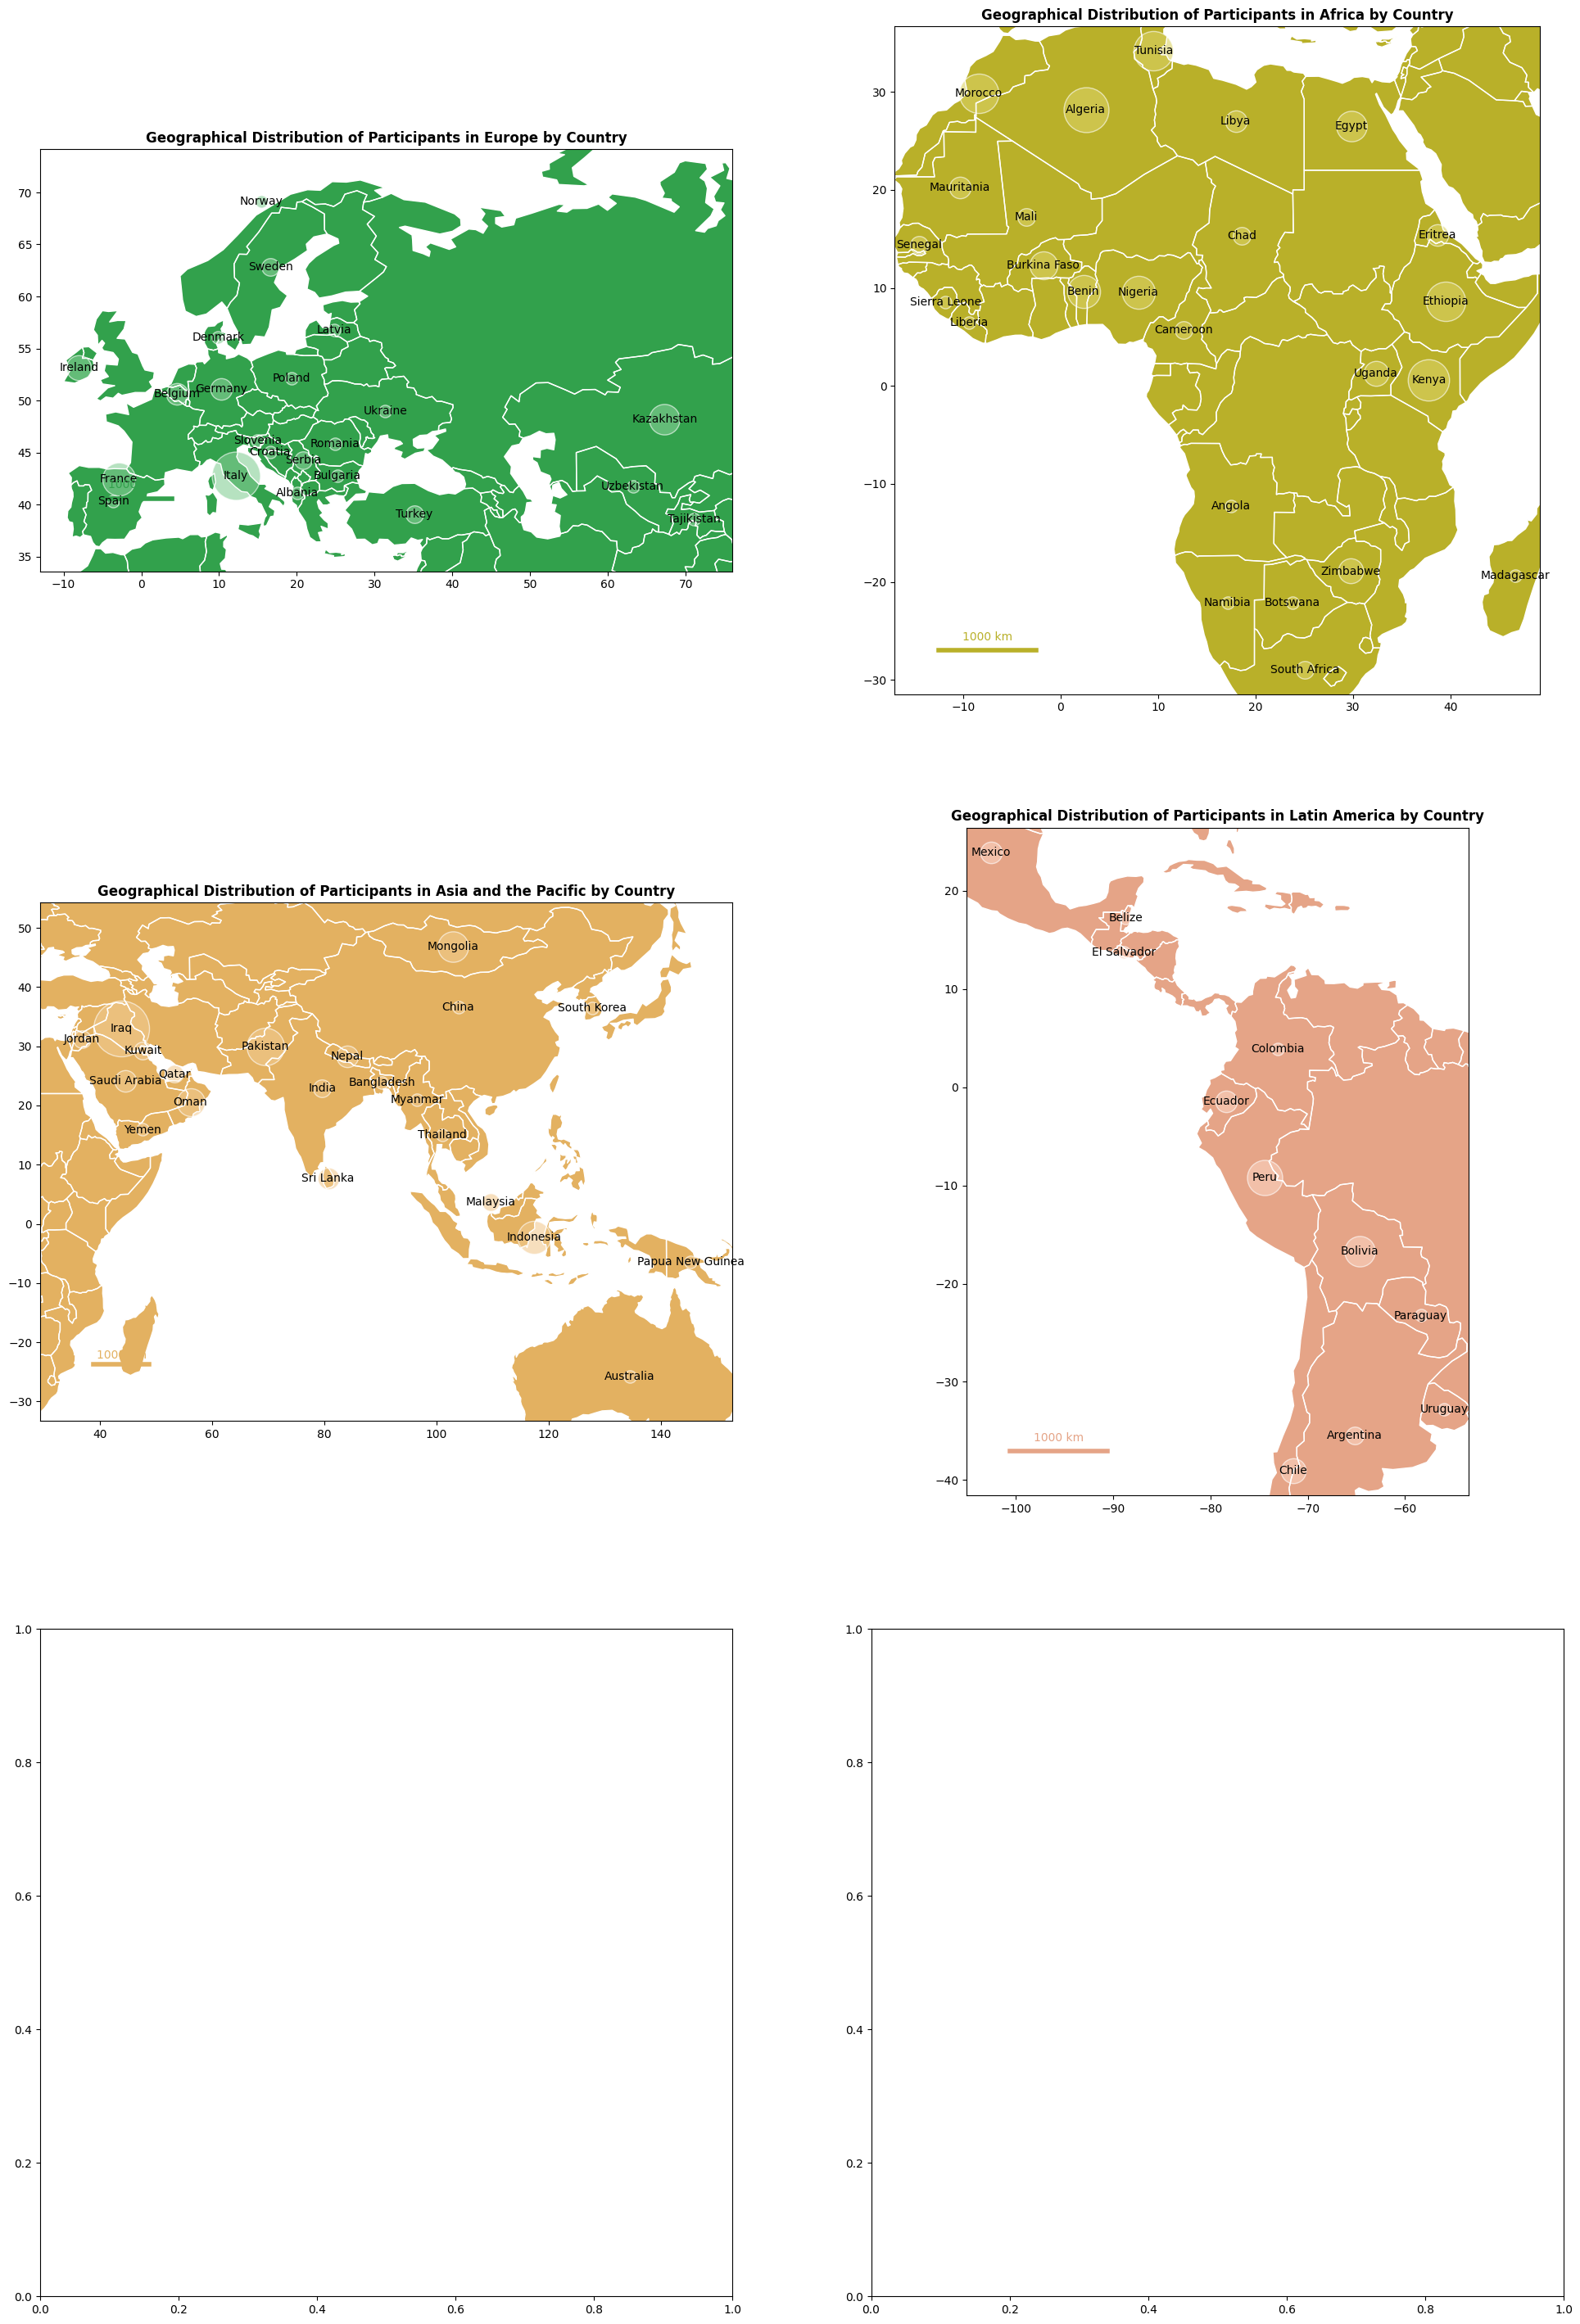

In [20]:
# Read the processed Excel file
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())

# 颜色搭配
color_schemes = [
    ['#32a14c', '#86cf97'],  # Asia and the Pacific
    ['#b9b029', '#dbd365'],  # Africa
    ['#e3b161', '#f2cb91'],  # Europe
    ['#e5a487', '#fcd3c1'],  # Latin America
    ['#8681b8', '#c7c4e2'],  # North America
]

# 获取国家的几何中心
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs("EPSG:4326")  # 确保使用WGS84坐标系
world['centroid'] = world['geometry'].centroid

# 为数据框中的每个国家分配几何中心
df['country_centroid'] = df['Country Name'].map(lambda x: world[world['name'] == x]['centroid'].values[0] if x in world['name'].values else None)

# 将几何中心分为经度和纬度
df['centroid_lon'] = df['country_centroid'].apply(lambda x: x.x if x else None)
df['centroid_lat'] = df['country_centroid'].apply(lambda x: x.y if x else None)

# Step 3: 可视化

# 1. Map with country-level participant bubbles
def plot_country_bubble_map(ax, df, title, world, continents):
    world.boundary.plot(ax=ax, linewidth=1, color='white')
    world.plot(ax=ax, color='#99cc00')  # 陆地填充颜色

    country_counts = df['Country Name'].value_counts()
    for country, count in country_counts.items():
        country_data = df[df['Country Name'] == country]
        mean_lat = country_data['centroid_lat'].mean()
        mean_lon = country_data['centroid_lon'].mean()
        ax.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#003399', edgecolors='white')
        ax.text(mean_lon, mean_lat, str(count), fontsize=10, color='white', ha='center', va='center', fontname='Arial')

    for continent, (x, y) in continents.items():
        ax.text(x, y, continent, fontsize=20, color='#aaaaaa', weight='bold', fontname='Arial')

    ax.set_title(title, fontname='Arial', weight='bold')

    # 添加比例尺
    scale_color = '#99cc00'
    ax.plot([-170, -160], [-80, -80], color=scale_color, linewidth=4)
    ax.text(-165, -82, '1000 km', fontsize=10, color=scale_color, ha='center', fontname='Arial')

# 2. Maps for each region with country-level participant bubbles
def plot_region_bubble_maps(df, color_schemes):
    regions = df['Iaea Region Name'].unique()
    regions = [region for region in regions if region != '']
    num_regions = len(regions)
    fig, axes = plt.subplots((num_regions + 1) // 2, 2, figsize=(24, (num_regions + 1) // 2 * 12))
    axes = axes.flatten()

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for i, (region, colors) in enumerate(zip(regions, color_schemes)):
        region_df = df[df['Iaea Region Name'] == region]

        if region == 'Europe':
            buffer = 10  # 调整欧洲的缓冲区
        elif region == 'Asia and the Pacific':
            buffer = 15  # 调整Asia and the Pacific的缓冲区
        else:
            buffer = 5

        # 获取区域内国家的子集
        region_world = world.cx[region_df['centroid_lon'].min()-buffer:region_df['centroid_lon'].max()+buffer,
                        region_df['centroid_lat'].min()-buffer:region_df['centroid_lat'].max()+buffer]

        axes[i].set_xlim(region_df['centroid_lon'].min()-buffer/2, region_df['centroid_lon'].max()+buffer/2)
        axes[i].set_ylim(region_df['centroid_lat'].min()-buffer/2, region_df['centroid_lat'].max()+buffer/2)

        region_world.boundary.plot(ax=axes[i], linewidth=1, color='white')
        region_world.plot(ax=axes[i], color=colors[0])  # 陆地填充颜色

        region_country_counts = region_df['Country Name'].value_counts()
        for country, count in region_country_counts.items():
            country_data = region_df[region_df['Country Name'] == country]
            mean_lat = country_data['centroid_lat'].mean()
            mean_lon = country_data['centroid_lon'].mean()

            # 针对中欧部分的国家进行特殊处理，不进行标注
            if region == 'Europe' and country in ['Austria', 'Switzerland', 'Hungary', 'Czechia']:
                continue

            # 移动Qatar标注位置
            if country == 'Qatar':
                mean_lon += 2  # 向右移动
            axes[i].scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color=colors[1], edgecolors='white')
            axes[i].text(mean_lon, mean_lat, country, fontsize=10, color='black', ha='center', va='center', fontname='Arial')

        axes[i].set_title(f'Geographical Distribution of Participants in {region} by Country', fontname='Arial', weight='bold')

        # 添加比例尺
        axes[i].plot([region_df['centroid_lon'].min()+2, region_df['centroid_lon'].min()+12],
                     [region_df['centroid_lat'].min()+2, region_df['centroid_lat'].min()+2],
                     color=colors[0], linewidth=4)
        axes[i].text(region_df['centroid_lon'].min()+7, region_df['centroid_lat'].min()+3,
                     '1000 km', fontsize=10, color=colors[0], ha='center', fontname='Arial')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# 世界地图
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 调整大图的显示范围，露出更多北半球区域，隐藏南极
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 90)

continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (55, 30),
    'Europe': (10, 55),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

plot_country_bubble_map(ax, df, 'Geographical Distribution of Participants by Country', world, continents)

# 各区域地图
plot_region_bubble_maps(df, color_schemes)


   Institution ID                                   Institution Name  \
0              14  Friedrich-Loeffler-Institute (FLI) - Jena;Fede...   
1             119  Ministry of Agriculture (MOA) and Rural Develo...   
2             119  Ministry of Agriculture (MOA) and Rural Develo...   
3             191        Minister of Agriculture;Veterinary Services   
4             423  Institute for Livestock Research and Developme...   

                                    Address                 Place  \
0                       Naumburger Str. 96a            07743 Jena   
1  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
2  18 Borrowdale Rd, PO Box CY 551 Causeway                Harare   
3                       30 rue Alain Savary  1002 Tunis Belvédère   
4                     Farcha street; BP 433             N'Djamena   

  Country Name Iaea Region Name         Participant Name Gender Date Of Birth  \
0      Germany           Europe       SEYBOLDT Christian   Male        

<ipython-input-25-032ae0e41a4e>:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-25-032ae0e41a4e>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centroid'] = world['geometry'].centroid


<ipython-input-25-032ae0e41a4e>:143: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
<ipython-input-25-032ae0e41a4e>:86: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

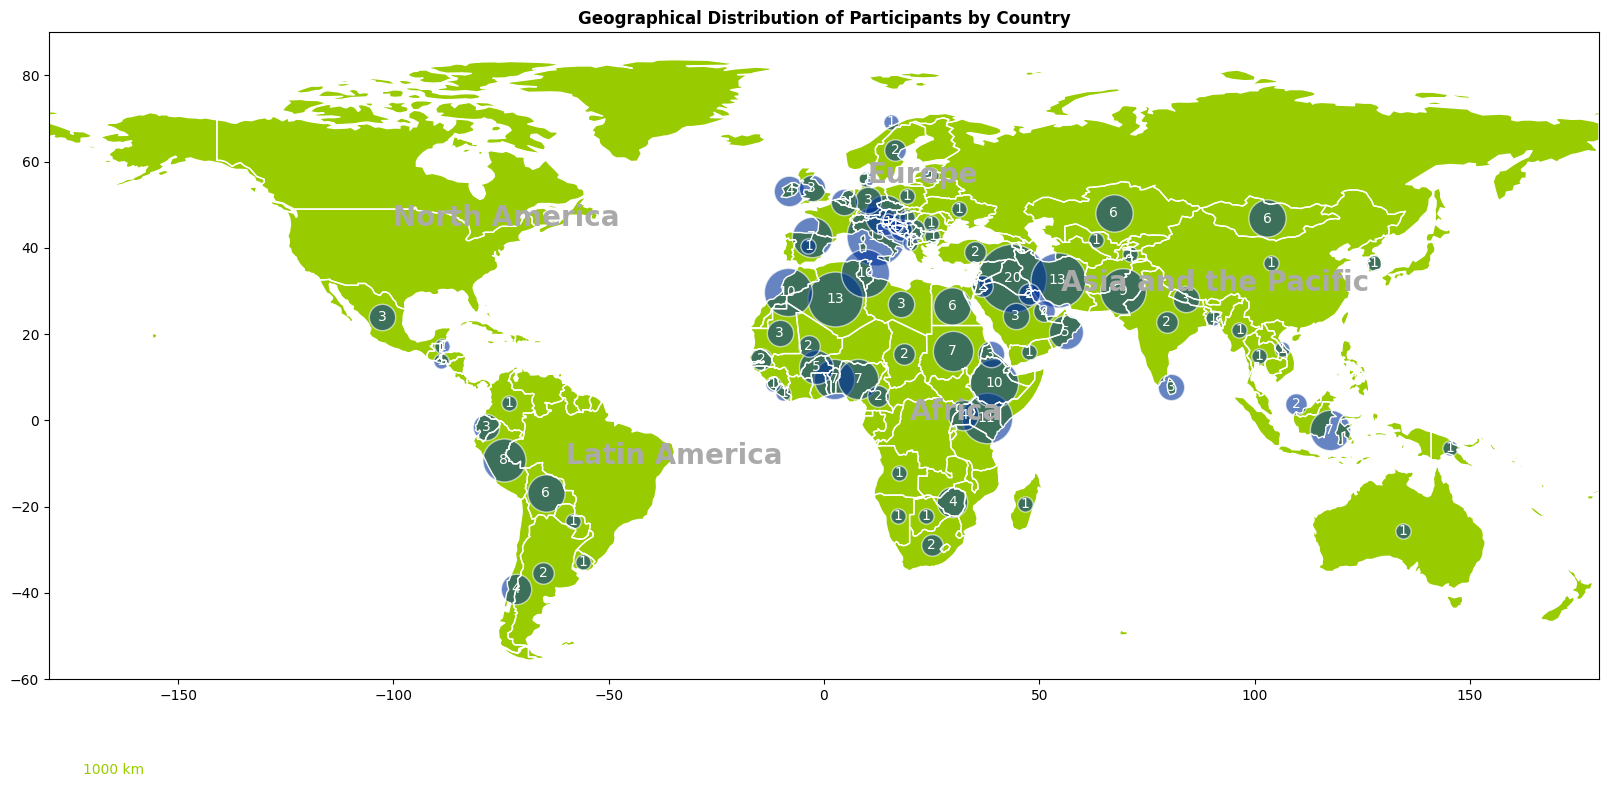

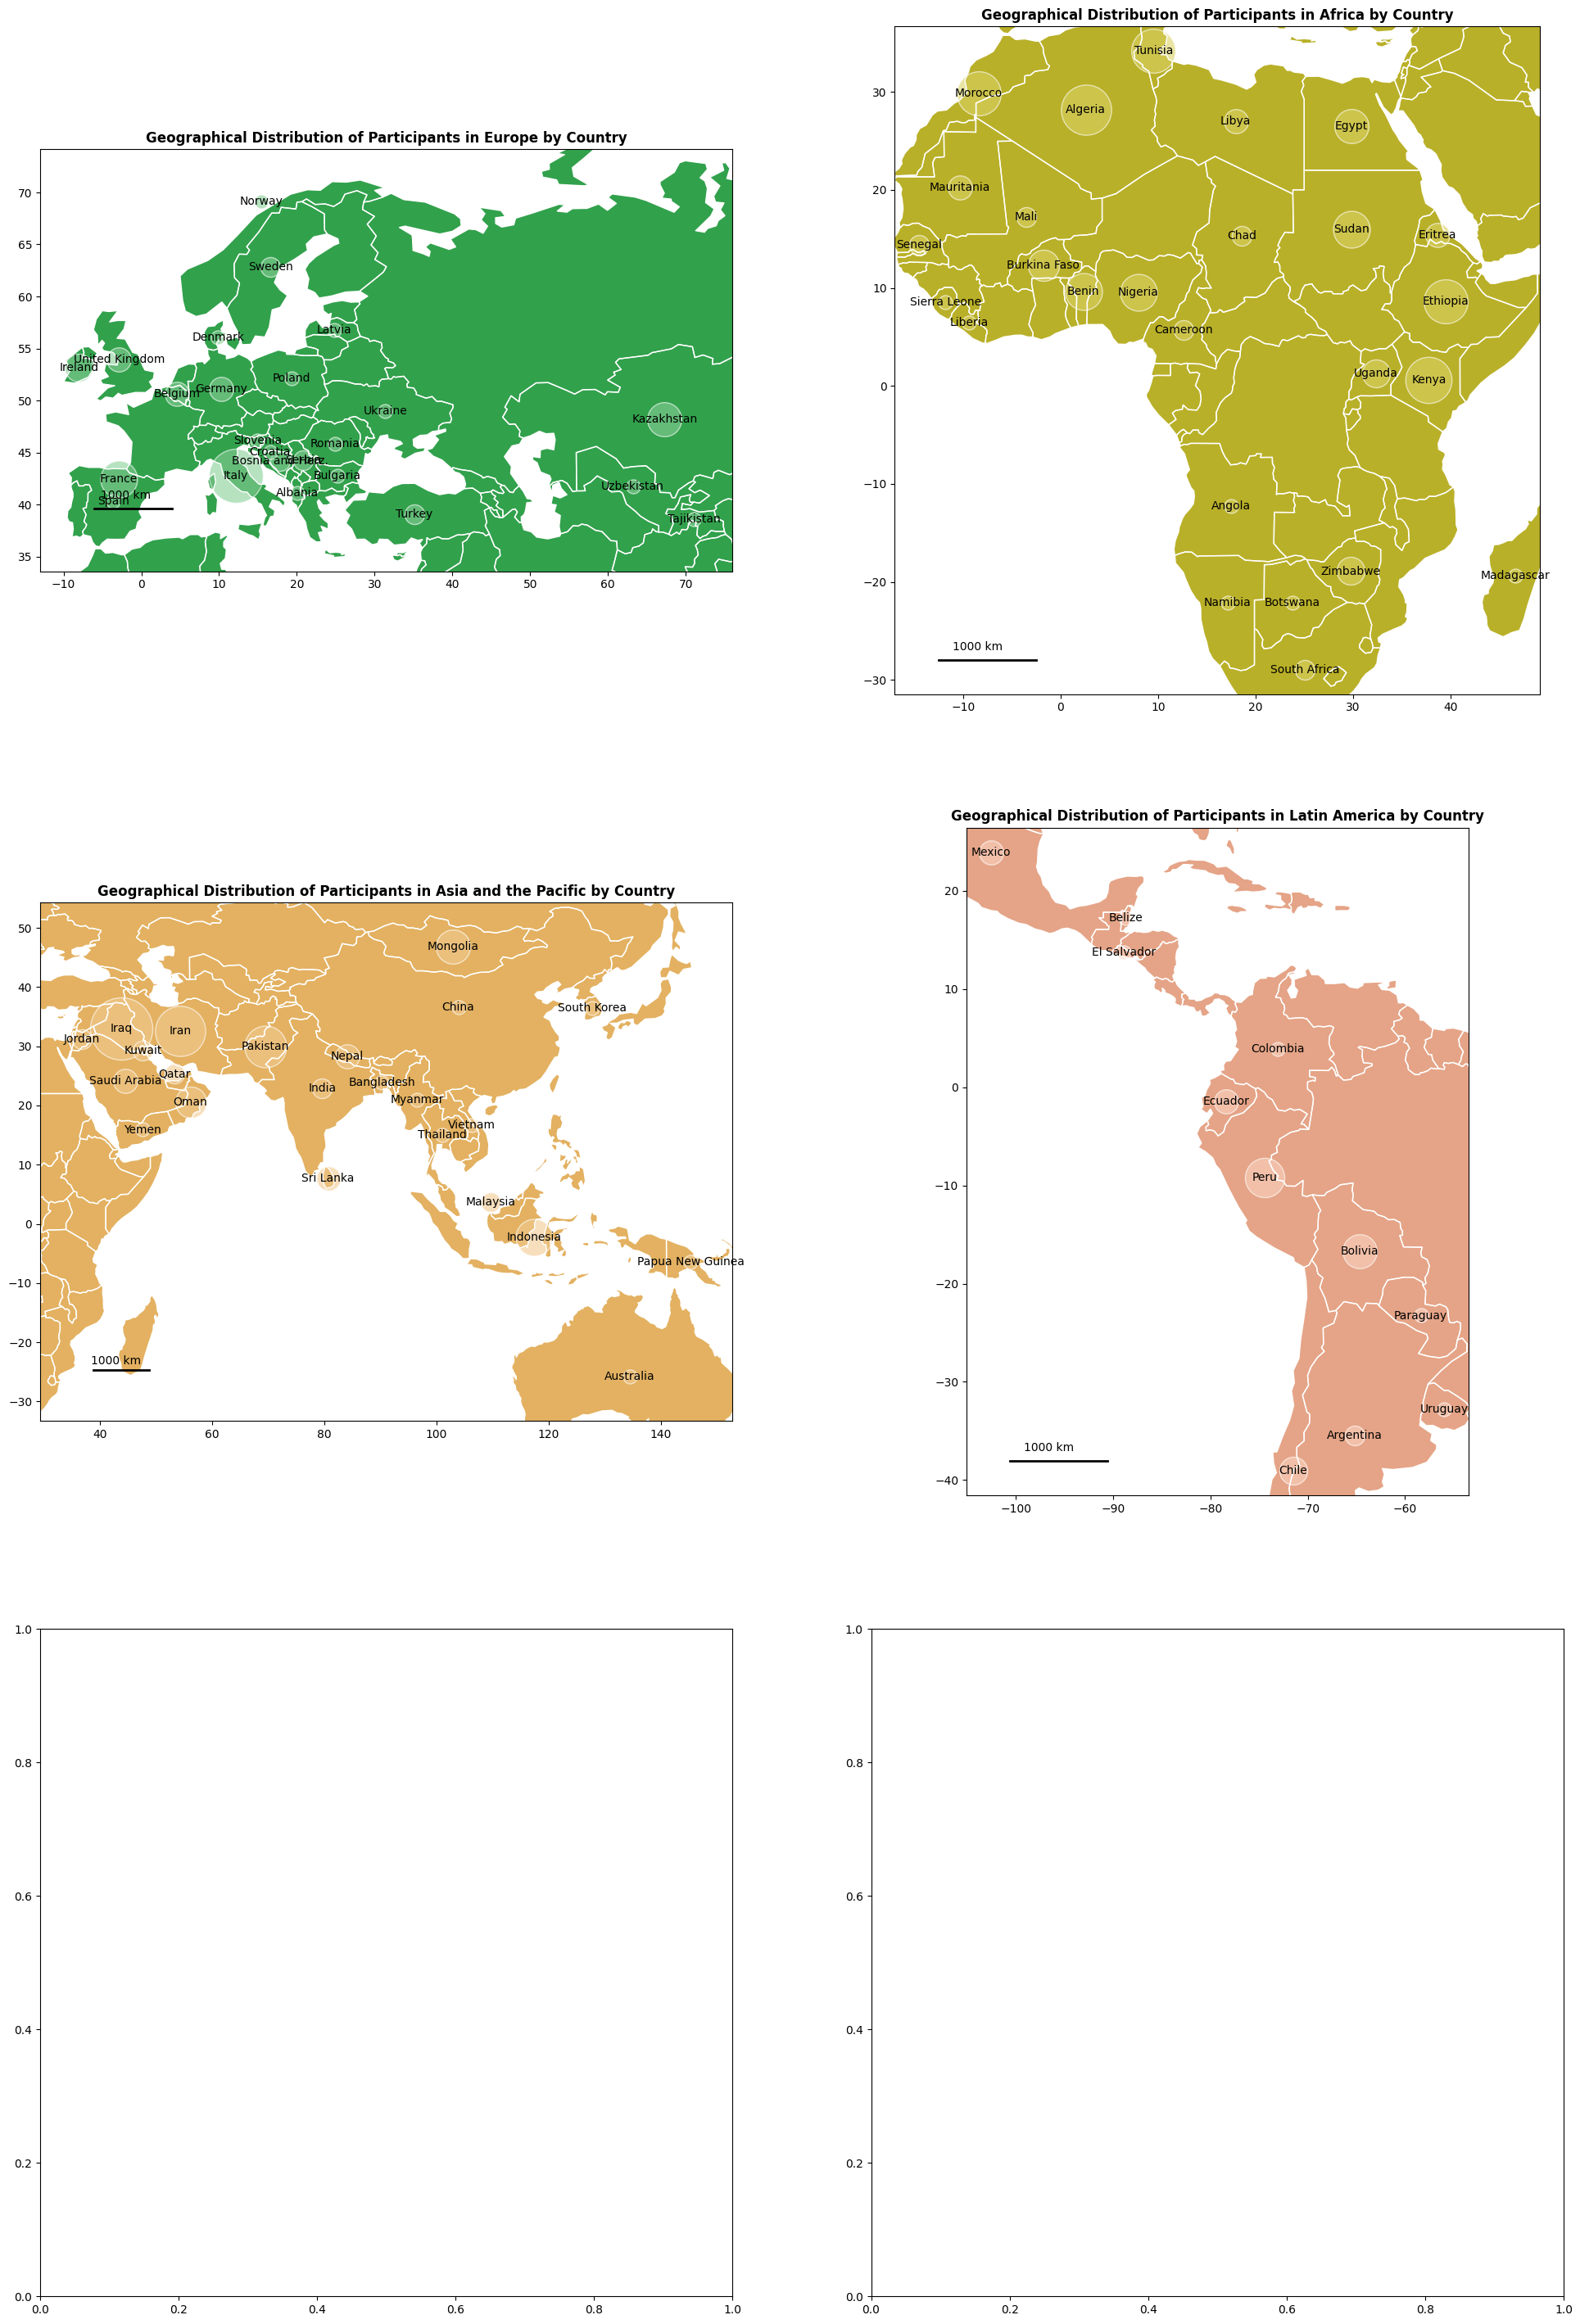

In [25]:
# 读取处理后的Excel文件
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())

# 地理数据框架
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Institution Longitude'], df['Institution Latitude']),
    crs="EPSG:4326"
)

# 读取世界地图数据
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 确保使用WGS84坐标系
world = world.to_crs("EPSG:4326")
world['centroid'] = world['geometry'].centroid

# 修正国家名称以匹配地理数据集
country_name_mapping = {
    'United States of America (the)': 'United States',
    'United Kingdom (the)': 'United Kingdom',
    'Sudan (the)': 'Sudan',
    'Iran (Islamic Republic of)': 'Iran',
    'Viet Nam': 'Vietnam',
    'Bosnia and Herzegovina': 'Bosnia and Herz.'
}

df['Country Name'] = df['Country Name'].replace(country_name_mapping)

# 获取国家的几何中心
def get_country_centroid(country_name, world):
    try:
        return world[world['name'] == country_name]['centroid'].values[0]
    except IndexError:
        print(f"Warning: {country_name} not found in world dataset")
        return None

df['country_centroid'] = df['Country Name'].apply(lambda x: get_country_centroid(x, world))

# 将几何中心分为经度和纬度
df['centroid_lon'] = df['country_centroid'].apply(lambda x: x.x if x else None)
df['centroid_lat'] = df['country_centroid'].apply(lambda x: x.y if x else None)

# 颜色搭配
color_schemes = [
    ['#32a14c', '#86cf97'],  # Asia and the Pacific
    ['#b9b029', '#dbd365'],  # Africa
    ['#e3b161', '#f2cb91'],  # Europe
    ['#e5a487', '#fcd3c1'],  # Latin America
    ['#8681b8', '#c7c4e2'],  # North America
]

# 1. 地理分布图
def plot_country_bubble_map(ax, df, title, world, continents):
    world.boundary.plot(ax=ax, linewidth=1, color='white')
    world.plot(ax=ax, color='#99cc00')  # 陆地填充颜色

    country_counts = df['Country Name'].value_counts()
    for country, count in country_counts.items():
        country_data = df[df['Country Name'] == country]
        mean_lat = country_data['centroid_lat'].mean()
        mean_lon = country_data['centroid_lon'].mean()
        ax.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#003399', edgecolors='white')
        ax.text(mean_lon, mean_lat, str(count), fontsize=10, color='white', ha='center', va='center', fontname='Arial')

    for continent, (x, y) in continents.items():
        ax.text(x, y, continent, fontsize=20, color='#aaaaaa', weight='bold', fontname='Arial')

    ax.set_title(title, fontname='Arial', weight='bold')

    # 添加比例尺
    scale_color = '#99cc00'
    ax.plot([-170, -160], [-80, -80], color=scale_color, linewidth=4)
    ax.text(-165, -82, '1000 km', fontsize=10, color=scale_color, ha='center', fontname='Arial')

# 2. 各区域地图
def plot_region_bubble_maps(df, color_schemes):
    regions = df['Iaea Region Name'].unique()
    regions = [region for region in regions if region != '']
    num_regions = len(regions)
    fig, axes = plt.subplots((num_regions + 1) // 2, 2, figsize=(24, (num_regions + 1) // 2 * 12))
    axes = axes.flatten()

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for i, (region, colors) in enumerate(zip(regions, color_schemes)):
        region_df = df[df['Iaea Region Name'] == region]

        if region == 'Europe':
            buffer = 10  # 调整欧洲的缓冲区
        elif region == 'Asia and the Pacific':
            buffer = 15  # 调整Asia and the Pacific的缓冲区
        elif region == 'North America':
            buffer = 20  # 调整North America的缓冲区
        else:
            buffer = 5

        # 获取区域内国家的子集
        region_world = world.cx[region_df['centroid_lon'].min()-buffer:region_df['centroid_lon'].max()+buffer,
                                region_df['centroid_lat'].min()-buffer:region_df['centroid_lat'].max()+buffer]

        axes[i].set_xlim(region_df['centroid_lon'].min()-buffer/2, region_df['centroid_lon'].max()+buffer/2)
        axes[i].set_ylim(region_df['centroid_lat'].min()-buffer/2, region_df['centroid_lat'].max()+buffer/2)

        region_world.boundary.plot(ax=axes[i], linewidth=1, color='white')
        region_world.plot(ax=axes[i], color=colors[0])  # 陆地填充颜色

        region_country_counts = region_df['Country Name'].value_counts()
        for country, count in region_country_counts.items():
            country_data = region_df[region_df['Country Name'] == country]
            mean_lat = country_data['centroid_lat'].mean()
            mean_lon = country_data['centroid_lon'].mean()

            # 针对中欧部分的国家进行特殊处理，不进行标注
            if region == 'Europe' and country in ['Austria', 'Switzerland', 'Hungary', 'Czechia']:
                continue

            # 移动Qatar标注位置
            if country == 'Qatar':
                mean_lon += 2  # 向右移动
            axes[i].scatter(mean_lon, mean_lat, s=count*150, alpha=0.6, color=colors[1], edgecolors='white')
            axes[i].text(mean_lon, mean_lat, country, fontsize=10, color='black', ha='center', va='center', fontname='Arial')

        axes[i].set_title(f'Geographical Distribution of Participants in {region} by Country', fontname='Arial', weight='bold')

        # 添加比例尺
        axes[i].plot([region_df['centroid_lon'].min()+2, region_df['centroid_lon'].min()+12],
                     [region_df['centroid_lat'].min()+1, region_df['centroid_lat'].min()+1],
                     color='black', linewidth=2)
        axes[i].text(region_df['centroid_lon'].min()+6, region_df['centroid_lat'].min()+2,
                     '1000 km', fontsize=10, color='black', ha='center', fontname='Arial')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# 世界地图
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 调整大图的显示范围，露出更多北半球区域，隐藏南极
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 90)

continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (55, 30),
    'Europe': (10, 55),
    'Africa': (20, 0),
    'Latin America': (-60, -10)
}

plot_country_bubble_map(ax, df, 'Geographical Distribution of Participants by Country', world, continents)

# 各区域地图
plot_region_bubble_maps(df, color_schemes)

In [1]:
# 读取处理后的Excel文件
file_path = '/content/drive/MyDrive/data/Event Participants.xlsx'
df = pd.read_excel(file_path)
print(df.head())

# 地理数据框架
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Institution Longitude'], df['Institution Latitude']),
    crs="EPSG:4326"
)

# 读取世界地图数据
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 确保使用WGS84坐标系
world = world.to_crs("EPSG:4326")
world['centroid'] = world['geometry'].centroid

# 修正国家名称以匹配地理数据集
country_name_mapping = {
    'United States of America (the)': 'United States',
    'United Kingdom (the)': 'United Kingdom',
    'Sudan (the)': 'Sudan',
    'Iran (Islamic Republic of)': 'Iran',
    'Viet Nam': 'Vietnam',
    'Bosnia and Herzegovina': 'Bosnia and Herz.'
}

df['Country Name'] = df['Country Name'].replace(country_name_mapping)

# 获取国家的几何中心
def get_country_centroid(country_name, world):
    try:
        return world[world['name'] == country_name]['centroid'].values[0]
    except IndexError:
        print(f"Warning: {country_name} not found in world dataset")
        return None

df['country_centroid'] = df['Country Name'].apply(lambda x: get_country_centroid(x, world))

# 将几何中心分为经度和纬度
df['centroid_lon'] = df['country_centroid'].apply(lambda x: x.x if x else df[df['Country Name'] == x]['Institution Longitude'].mean())
df['centroid_lat'] = df['country_centroid'].apply(lambda x: x.y if x else df[df['Country Name'] == x]['Institution Latitude'].mean())

# 颜色搭配
color_schemes = [
    ['#86cf97', '#32a14c'],  # Asia and the Pacific
    ['#b9b029', '#dbd365'],  # Africa
    ['#e3b161', '#f2cb91'],  # Europe
    ['#e5a487', '#fcd3c1'],  # Latin America
    ['#8681b8', '#c7c4e2'],  # North America
]

# 1. 地理分布图
def plot_country_bubble_map(ax, df, title, world, continents):
    world.boundary.plot(ax=ax, linewidth=0.4, color='white')
    world.plot(ax=ax, color='#99cc00')  # 陆地填充颜色

    country_counts = df['Country Name'].value_counts()
    for country, count in country_counts.items():
        country_data = df[df['Country Name'] == country]
        mean_lat = country_data['centroid_lat'].mean()
        mean_lon = country_data['centroid_lon'].mean()
        ax.scatter(mean_lon, mean_lat, s=count*120, alpha=0.6, color='#003399', edgecolors='white')
        ax.text(mean_lon, mean_lat, str(count), fontsize=10, color='white', ha='center', va='center', fontname='Arial')

    # 为美国添加特定的气泡
    us_count = 12
    us_lon, us_lat = -95.7129, 37.0902  # 美国的经纬度中心
    ax.scatter(us_lon, us_lat, s=us_count*120, alpha=0.6, color='#003399', edgecolors='white')
    ax.text(us_lon, us_lat, str(us_count), fontsize=10, color='white', ha='center', va='center', fontname='Arial')

    for continent, (x, y) in continents.items():
        ax.text(x, y, continent, fontsize=20, color='#aaaaaa', weight='bold', fontname='Arial', zorder=1)

    ax.set_title(title, fontname='Arial', weight='bold')

# 2. 各区域地图
def plot_region_bubble_maps(df, color_schemes):
    regions = df['Iaea Region Name'].unique()
    regions = [region for region in regions if region != '']
    num_regions = len(regions)
    fig, axes = plt.subplots((num_regions + 1) // 2, 2, figsize=(24, (num_regions + 1) // 2 * 12))
    axes = axes.flatten()

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for i, (region, colors) in enumerate(zip(regions, color_schemes)):
        region_df = df[df['Iaea Region Name'] == region]

        if region == 'Europe':
            buffer = 10  # 调整欧洲的缓冲区
        elif region == 'Asia and the Pacific':
            buffer = 15  # 调整Asia and the Pacific的缓冲区
        elif region == 'North America':
            buffer = 15  # 调整North America的缓冲区
        else:
            buffer = 5

        # 获取区域内国家的子集
        region_world = world.cx[region_df['centroid_lon'].min()-20:region_df['centroid_lon'].max()+20,
                                region_df['centroid_lat'].min()-20:region_df['centroid_lat'].max()+20]

        axes[i].set_xlim(region_df['centroid_lon'].min()-10, region_df['centroid_lon'].max()+10)
        axes[i].set_ylim(region_df['centroid_lat'].min()-10, region_df['centroid_lat'].max()+10)

        region_world.boundary.plot(ax=axes[i], linewidth=1, color='white')
        region_world.plot(ax=axes[i], color=colors[0])  # 陆地填充颜色

        region_country_counts = region_df['Country Name'].value_counts()
        for country, count in region_country_counts.items():
            country_data = region_df[region_df['Country Name'] == country]
            mean_lat = country_data['centroid_lat'].mean()
            mean_lon = country_data['centroid_lon'].mean()

            # 针对中欧部分的国家进行特殊处理，不进行标注
            if region == 'Europe' and country in ['Austria', 'Switzerland', 'Hungary', 'Czechia']:
                continue

            # 移动Qatar标注位置
            if country == 'Qatar':
                mean_lon += 2  # 向右移动
            axes[i].scatter(mean_lon, mean_lat, s=count*180, alpha=0.6, color=colors[1], edgecolors='white')
            axes[i].text(mean_lon, mean_lat, country, fontsize=10, color='black', ha='center', va='center')

        # 为美国添加特定的气泡（North America区域）
        if region == 'North America':
            us_lon, us_lat = -95.7129, 37.0902
            axes[i].scatter(us_lon, us_lat, s=12*180, alpha=0.6, color=colors[1], edgecolors='white')
            axes[i].text(us_lon, us_lat, 'United States', fontsize=10, color='black', ha='center', va='center')

        axes[i].set_title(f'Geographical Distribution of Participants in {region} by Country',  weight='bold')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# 世界地图
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 调整大图的显示范围，露出更多北半球区域，隐藏南极
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 90)

continents = {
    'North America': (-100, 45),
    'Asia and the Pacific': (100, 30),
    'Europe': (10, 58),
    'Africa': (10, 0),
    'Latin America': (-60, -10)
}

plot_country_bubble_map(ax, df, 'Geographical Distribution of Participants by Country', world, continents)

# 各区域地图
plot_region_bubble_maps(df, color_schemes)


NameError: name 'pd' is not defined

<ipython-input-43-2c653a765373>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


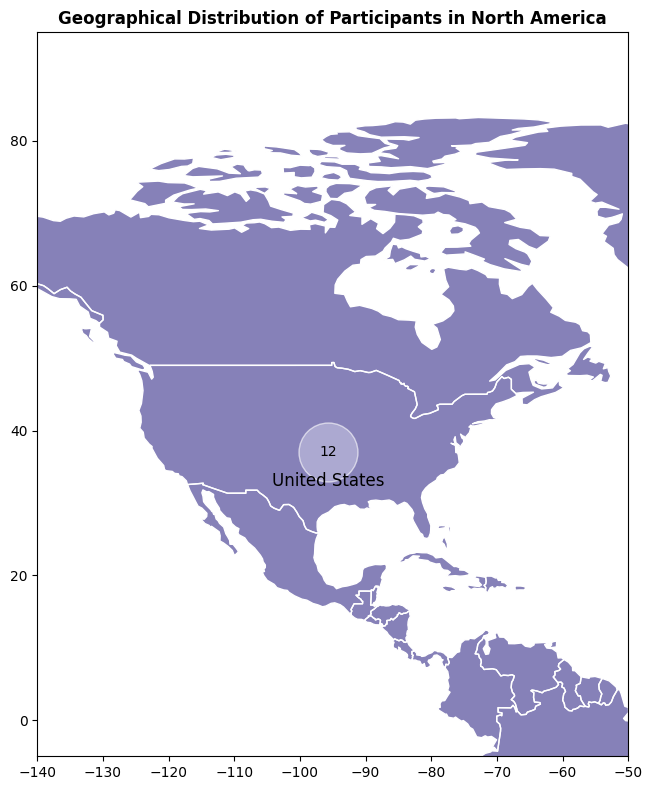

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取世界地图数据
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 确保使用WGS84坐标系
world = world.to_crs("EPSG:4326")

# 北美地图的颜色搭配
na_color_scheme = ['#8681b8', '#c7c4e2']

# 绘制北美区域地图
def plot_north_america_map():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    buffer = 20  # 调整North America的缓冲区

    # 获取北美区域的子集
    north_america_world = world.cx[-170:-30, 5:85]

    ax.set_xlim(-130-buffer/2, -60+buffer/2)
    ax.set_ylim(5-buffer/2, 85+buffer/2)

    north_america_world.boundary.plot(ax=ax, linewidth=1, color='white')
    north_america_world.plot(ax=ax, color=na_color_scheme[0])  # 陆地填充颜色

    # 为美国添加特定的气泡（North America区域）
    us_lon, us_lat = -95.7129, 37.0902
    count = 12  # 假设美国有12个参与者
    ax.scatter(us_lon, us_lat, s=count*150, alpha=0.6, color=na_color_scheme[1], edgecolors='white')
    ax.text(us_lon, us_lat, str(count), fontsize=10, color='black', ha='center', va='center', fontname='Arial')
    ax.text(us_lon, us_lat - 4, 'United States', fontsize=12, color='black', ha='center', va='center', fontname='Arial')

    ax.set_title('Geographical Distribution of Participants in North America', fontname='Arial', weight='bold')

    plt.tight_layout()
    plt.show()

# 调用绘制北美地图的函数
plot_north_america_map()
